In [1]:
import pandas as pd
import numpy as np
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import math
import shap
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
import bamboolib as bam

### Read Data

In [2]:
## Read Clean Data From Folder
path = r'C_data'
db_dir = glob.glob(path + "/*.csv")

li = []

for i in db_dir:
    df = pd.read_csv(i, index_col=None, header=0)
    li.append(df)
ori_db = pd.concat(li, ignore_index=True)
wtpc = pd.read_csv('Design Capacity WTP.csv')
master_db = pd.merge(ori_db,wtpc[['wtp','Water Source','Lembangan']],on='wtp',how='left')
master_db['Date'] = pd.to_datetime(master_db['Date'])

### General Data Cleaning

In [3]:
## Define Outliers Removal Function
def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 1.5)
    upper_limit = s.mean() + (s.std() * 1.5)
    return ~s.between(lower_limit, upper_limit)

In [4]:
## Rate of change variables ("..._chpctm") vs agaisnt median value of respective WTP
tv = ['Disinfectant_chpctm','pH Adjuster_chpctm','Coagulant_chpctm']
idv = ['pH_avg_chpctm', 'Turbidity_avg_chpctm','Color_avg_chpctm', 'Iron_avg_chpctm', 'Ammonia_avg_chpctm', 'Manganese_avg_chpctm']
master_db[idv] = master_db[idv].fillna(0)
to_c5 = master_db.copy()
to_c5 = to_c5[tv+idv+['Lembangan','wtp','Date']].copy()
to_c5 = to_c5[~to_c5.isin([np.inf, -np.inf]).any(1)].copy()
to_c5 = to_c5.dropna()
ge2 = tv + idv

In [5]:
ge2

['Disinfectant_chpctm',
 'pH Adjuster_chpctm',
 'Coagulant_chpctm',
 'pH_avg_chpctm',
 'Turbidity_avg_chpctm',
 'Color_avg_chpctm',
 'Iron_avg_chpctm',
 'Ammonia_avg_chpctm',
 'Manganese_avg_chpctm']

In [6]:
opp = pd.DataFrame()
for i in ge2:
    
    if i==ge2[0]:
        m0 = to_c5[~to_c5.groupby(['Lembangan','wtp'])[i].apply(is_outlier)][['Lembangan','wtp',i,'Date']]
        opp = opp.append(m0)
    else:
        m1 = to_c5[~to_c5.groupby(['Lembangan','wtp'])[i].apply(is_outlier)][['Lembangan','wtp',i,'Date']]
        opp = pd.merge(opp,m1,on=['Lembangan','wtp','Date'],how='left')

In [7]:
opp = opp.dropna()
opp.shape

(3913, 12)

## Modelling (Feature Importance)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sys import stdout
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble  import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor

In [9]:
## Random Forest Optimization
def rfopt(Xr_train,y_train,Xr_test,y_test):
    score = {"fea":[],"rscore":[],"MSE":[]}
    max_depth = [10, 20, 30, 40]
    n_estimators = [100, 200, 300]
    for i in max_depth:
        
        for j in n_estimators:
            rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=j, max_depth=i, random_state=0)).fit(Xr_train, y_train)
            rs = round(rf.score(Xr_train,y_train)*100,2)
            rf_pr = rf.predict(Xr_test)
            ms = round(mean_squared_error(y_test,rf_pr),2)
            score["fea"].append(f"max_depth{i} n_est:{j}")
            score["rscore"].append(rs)
            score["MSE"].append(ms)
            del rf
            gc.collect()
    return score

## Sungai Langat

In [10]:
wwt = 'Sg Langat'
## Common Target
to_c7 = opp[opp['Lembangan']==wwt].copy()
y = to_c7[tv].copy()
X = to_c7[idv].copy()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [11]:
rfoptsc = rfopt(X_train,y_train,X_test,y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

KeyboardInterrupt: 

In [1073]:
max_depth = 20
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)
rfdic = [
rf.estimators_[0].feature_importances_,
rf.estimators_[1].feature_importances_,
rf.estimators_[2].feature_importances_]
rap = pd.DataFrame({'Feature':X_train.columns})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")

,Feature,Disinfectant_chpctm,pH Adjuster_chpctm,Coagulant_chpctm
0,pH_avg_chpctm,0.175274,0.118858,0.098725
1,Turbidity_avg_chpctm,0.132150,0.180394,0.383296
2,Color_avg_chpctm,0.116449,0.127104,0.136068
3,Iron_avg_chpctm,0.187947,0.136041,0.160626
4,Ammonia_avg_chpctm,0.274053,0.172840,0.119105
5,Manganese_avg_chpctm,0.114128,0.264763,0.102179


R Square Result 89.94%
MSE 158.21


## Sg Klang

In [1074]:
wwt = 'Sg Klang'
## Common Target
to_c7 = opp[opp['Lembangan']==wwt].copy()
y = to_c7[tv].copy()
X = to_c7[idv].copy()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [1075]:
rfoptsc = rfopt(X_train,y_train,X_test,y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

,fea,rscore,MSE,Error
0,max_depth10 n_est:100,86.32,165.51,12.865069
1,max_depth10 n_est:200,86.66,164.03,12.807420
2,max_depth10 n_est:300,86.62,163.40,12.782801
3,max_depth20 n_est:100,90.43,166.79,12.914720
4,max_depth20 n_est:200,90.92,167.03,12.924009
5,max_depth20 n_est:300,90.93,165.31,12.857294
6,max_depth30 n_est:100,90.43,166.82,12.915882
7,max_depth30 n_est:200,90.92,166.71,12.911623
8,max_depth30 n_est:300,90.94,165.33,12.858071
9,max_depth40 n_est:100,90.43,166.82,12.915882


In [1076]:
max_depth = 20
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)
rfdic = [
rf.estimators_[0].feature_importances_,
rf.estimators_[1].feature_importances_,
rf.estimators_[2].feature_importances_]
rap = pd.DataFrame({'Feature':X_train.columns})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")

,Feature,Disinfectant_chpctm,pH Adjuster_chpctm,Coagulant_chpctm
0,pH_avg_chpctm,0.399854,0.255426,0.212185
1,Turbidity_avg_chpctm,0.161775,0.382469,0.432042
2,Color_avg_chpctm,0.116894,0.150343,0.238489
3,Iron_avg_chpctm,0.173466,0.101805,0.060055
4,Ammonia_avg_chpctm,0.130720,0.094535,0.053282
5,Manganese_avg_chpctm,0.017291,0.015422,0.003949


R Square Result 90.93%
MSE 165.31


## Sg Selangor

In [1077]:
wwt = 'Sg Selangor'
## Common Target
to_c7 = opp[opp['Lembangan']==wwt].copy()
y = to_c7[tv].copy()
X = to_c7[idv].copy()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [1078]:
rfoptsc = rfopt(X_train,y_train,X_test,y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

,fea,rscore,MSE,Error
0,max_depth10 n_est:100,72.14,170.94,13.074402
1,max_depth10 n_est:200,72.35,171.56,13.098091
2,max_depth10 n_est:300,72.33,170.80,13.069047
3,max_depth20 n_est:100,87.47,177.03,13.305262
4,max_depth20 n_est:200,87.65,176.94,13.301880
5,max_depth20 n_est:300,87.71,176.18,13.273281
6,max_depth30 n_est:100,88.14,178.10,13.345411
7,max_depth30 n_est:200,88.37,177.62,13.327415
8,max_depth30 n_est:300,88.46,176.59,13.288717
9,max_depth40 n_est:100,88.13,177.40,13.319159


In [1079]:
max_depth = 20
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)
rfdic = [
rf.estimators_[0].feature_importances_,
rf.estimators_[1].feature_importances_,
rf.estimators_[2].feature_importances_]
rap = pd.DataFrame({'Feature':X_train.columns})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")

,Feature,Disinfectant_chpctm,pH Adjuster_chpctm,Coagulant_chpctm
0,pH_avg_chpctm,0.160562,0.165902,0.112566
1,Turbidity_avg_chpctm,0.234119,0.236098,0.406530
2,Color_avg_chpctm,0.229019,0.220031,0.202706
3,Iron_avg_chpctm,0.151722,0.138945,0.107897
4,Ammonia_avg_chpctm,0.129025,0.152605,0.095559
5,Manganese_avg_chpctm,0.095553,0.086419,0.074742


R Square Result 87.71%
MSE 176.18


## Sg Semantan

In [1080]:
wwt = 'Sg Semantan'
## Common Target
to_c7 = opp[opp['Lembangan']==wwt].copy()
y = to_c7[tv].copy()
X = to_c7[idv].copy()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [1081]:
rfoptsc = rfopt(X_train,y_train,X_test,y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

,fea,rscore,MSE,Error
0,max_depth10 n_est:100,92.33,234.35,15.308494
1,max_depth10 n_est:200,92.57,230.56,15.184202
2,max_depth10 n_est:300,92.66,233.98,15.296405
3,max_depth20 n_est:100,92.44,234.28,15.306208
4,max_depth20 n_est:200,92.74,232.15,15.236469
5,max_depth20 n_est:300,92.83,234.45,15.311760
6,max_depth30 n_est:100,92.44,234.24,15.304901
7,max_depth30 n_est:200,92.74,232.12,15.235485
8,max_depth30 n_est:300,92.83,234.46,15.312087
9,max_depth40 n_est:100,92.44,234.24,15.304901


In [1082]:
max_depth = 20
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)
rfdic = [
rf.estimators_[0].feature_importances_,
rf.estimators_[1].feature_importances_,
rf.estimators_[2].feature_importances_]
rap = pd.DataFrame({'Feature':X_train.columns})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")

,Feature,Disinfectant_chpctm,pH Adjuster_chpctm,Coagulant_chpctm
0,pH_avg_chpctm,0.101477,0.198384,0.251226
1,Turbidity_avg_chpctm,0.198466,0.087250,0.376016
2,Color_avg_chpctm,0.198212,0.168066,0.081647
3,Iron_avg_chpctm,0.377428,0.447788,0.167994
4,Ammonia_avg_chpctm,0.041385,0.042310,0.061462
5,Manganese_avg_chpctm,0.083032,0.056202,0.061656


R Square Result 92.83%
MSE 234.45


## Sg Tengi

In [1083]:
wwt = 'Sg Tengi'
## Common Target
to_c7 = opp[opp['Lembangan']==wwt].copy()
y = to_c7[tv].copy()
X = to_c7[idv].copy()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [1084]:
rfoptsc = rfopt(X_train,y_train,X_test,y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

,fea,rscore,MSE,Error
0,max_depth10 n_est:100,92.34,183.27,13.537725
1,max_depth10 n_est:200,92.26,182.34,13.503333
2,max_depth10 n_est:300,92.42,183.36,13.541049
3,max_depth20 n_est:100,92.73,185.76,13.629380
4,max_depth20 n_est:200,92.73,183.45,13.544372
5,max_depth20 n_est:300,92.86,184.48,13.582341
6,max_depth30 n_est:100,92.73,185.75,13.629013
7,max_depth30 n_est:200,92.73,183.44,13.544002
8,max_depth30 n_est:300,92.86,184.47,13.581973
9,max_depth40 n_est:100,92.73,185.75,13.629013


In [1085]:
max_depth = 20
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)
rfdic = [
rf.estimators_[0].feature_importances_,
rf.estimators_[1].feature_importances_,
rf.estimators_[2].feature_importances_]
rap = pd.DataFrame({'Feature':X_train.columns})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")

,Feature,Disinfectant_chpctm,pH Adjuster_chpctm,Coagulant_chpctm
0,pH_avg_chpctm,0.133225,0.344711,0.043770
1,Turbidity_avg_chpctm,0.154190,0.229853,0.802068
2,Color_avg_chpctm,0.257187,0.255153,0.078252
3,Iron_avg_chpctm,0.221609,0.065914,0.039759
4,Ammonia_avg_chpctm,0.170508,0.060554,0.025471
5,Manganese_avg_chpctm,0.063282,0.043816,0.010679


R Square Result 92.86%
MSE 184.48


## Sg Bernam

In [1086]:
wwt = 'Sg Bernam'
## Common Target
to_c7 = opp[opp['Lembangan']==wwt].copy()
y = to_c7[tv].copy()
X = to_c7[idv].copy()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [1087]:
rfoptsc = rfopt(X_train,y_train,X_test,y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

,fea,rscore,MSE,Error
0,max_depth10 n_est:100,88.12,600.92,24.513670
1,max_depth10 n_est:200,88.22,612.22,24.743080
2,max_depth10 n_est:300,88.21,613.03,24.759443
3,max_depth20 n_est:100,93.19,608.65,24.670833
4,max_depth20 n_est:200,93.30,617.98,24.859204
5,max_depth20 n_est:300,93.35,616.24,24.824182
6,max_depth30 n_est:100,93.25,608.61,24.670022
7,max_depth30 n_est:200,93.36,618.35,24.866644
8,max_depth30 n_est:300,93.39,617.15,24.842504
9,max_depth40 n_est:100,93.25,608.61,24.670022


In [1088]:
max_depth = 20
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)
rfdic = [
rf.estimators_[0].feature_importances_,
rf.estimators_[1].feature_importances_,
rf.estimators_[2].feature_importances_]
rap = pd.DataFrame({'Feature':X_train.columns})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")

,Feature,Disinfectant_chpctm,pH Adjuster_chpctm,Coagulant_chpctm
0,pH_avg_chpctm,0.600322,0.628616,0.260493
1,Turbidity_avg_chpctm,0.097559,0.054892,0.124362
2,Color_avg_chpctm,0.095286,0.141395,0.349935
3,Iron_avg_chpctm,0.085590,0.057930,0.109993
4,Ammonia_avg_chpctm,0.061638,0.078290,0.084674
5,Manganese_avg_chpctm,0.059605,0.038878,0.070543


R Square Result 93.35%
MSE 616.24


## General

In [12]:
to_c7 = opp.copy()
to_c7.shape
## Common Target
y = to_c7[tv].copy()
X = to_c7[idv].copy()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=88)

(3913, 12)

In [13]:
rfoptsc = rfopt(X_train,y_train,X_test,y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

                      fea  rscore     MSE      Error
0   max_depth10 n_est:100   59.33  238.91  15.456714
1   max_depth10 n_est:200   59.48  238.34  15.438264
2   max_depth10 n_est:300   59.58  237.57  15.413306
3   max_depth20 n_est:100   85.60  238.87  15.455420
4   max_depth20 n_est:200   85.86  237.53  15.412008
5   max_depth20 n_est:300   85.99  237.17  15.400325
6   max_depth30 n_est:100   89.62  240.14  15.496451
7   max_depth30 n_est:200   89.90  238.37  15.439236
8   max_depth30 n_est:300   90.01  237.43  15.408764
9   max_depth40 n_est:100   89.83  239.72  15.482894
10  max_depth40 n_est:200   90.10  238.69  15.449595
11  max_depth40 n_est:300   90.21  237.94  15.425304

In [14]:
max_depth = 20
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)
rfdic = [
rf.estimators_[0].feature_importances_,
rf.estimators_[1].feature_importances_,
rf.estimators_[2].feature_importances_]

In [15]:
rap = pd.DataFrame({'Feature':X_train.columns})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")

                Feature  Disinfectant_chpctm  pH Adjuster_chpctm  \
0         pH_avg_chpctm             0.219462            0.365170   
1  Turbidity_avg_chpctm             0.187635            0.133518   
2      Color_avg_chpctm             0.151427            0.168363   
3       Iron_avg_chpctm             0.185217            0.118387   
4    Ammonia_avg_chpctm             0.135053            0.107841   
5  Manganese_avg_chpctm             0.121206            0.106720   

   Coagulant_chpctm  
0          0.297001  
1          0.182234  
2          0.253083  
3          0.086216  
4          0.089393  
5          0.092073  

R Square Result 85.99%
MSE 237.17


In [18]:
## User Defined Weightage for each Chemical Products

## General Random Method
weight = np.array([0.3, 0.3, 0.4])

## Weightage Based on Cost
weight_c = np.array([0.395, 0.1224, 0.4826])

## Weightage Based on Dosing 
weight_d = np.array([0.1064, 0.1969, 0.6967])

In [19]:
## Refined Weightage
fw = RDF.iloc[:,1:].dot(weight_d)
fwc = RDF.iloc[:,1:].dot(weight_c)
#fwd = RDF.iloc[:,1:].dot(weight_d) # (Will be focus on this as user has agreed on this weightage)

## New Computation - Ikmal

In [530]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sys import stdout
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble  import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import glob

path = r'CP_data'
db_dir = glob.glob(path + "/*.csv")

jam3 = pd.concat([pd.read_csv(file, index_col=None, header=0) for file in db_dir])
jam3 = jam3.drop('Unnamed: 0', axis=1)
# define the conditions
condition = (jam3['wtp'] == 'Kuala Kubu Bharu') | (jam3['wtp'] == 'Batang Kali')| (jam3['wtp'] == 'Sungai Rangkap')

# use loc to update the values
jam3.loc[condition, 'Lembangan'] = 'Sungai Selangor Upstream'
jam3 = pd.concat([jam3, pd.get_dummies(jam3['Lembangan'])], axis=1)

jam4 = jam3[(jam3['wtp'] != 'Sungai Selangor Fasa 2 Stream C') & (jam3['wtp'] != 'Bukit Tampoi New')].copy()

idv = ['pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg', 'Manganese_avg']
exclude = ['Month', 'Quarter', 'Water Source', 'Lembangan', 'wtp', 'date', 'Date',
           'Liquid Chlorine (Pre)', 'Liquid Chlorine (Intermediate)', 'Liquid Chlorine (Post)',
           'Hydrated Lime (Intermediate)', 'Hydrated Lime (Powder) (Pre)', 'Hydrated Lime (Powder) (Post)',
           'Hydrated Lime (Post) (mg/L)', 'Liquid Chlorine (Post) (mg/L)', 'Liquid Chlorine (Pre) (mg/L)',
           'Hydrated Lime (Pre) (mg/L)', 'Hydrated Lime (Pre)', 'Hydrated Lime (Post)', 'Soda Ash (Pre)',
           'Soda Ash (Post)', 'Soda_Ash_T', 'Hydrated_Lime_T', 'Hydrated_Lime_Pow_T', 'Liquid_Chlorine_T',
           'Hydrated_Lime_T_Pow']

tv = [col for col in jam4.columns if col not in idv and col not in exclude]

jam4[tv] = jam4[tv].fillna(0)

X = jam4[idv].copy()
y = jam4[tv].copy()

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

## Random Forest Optimization
def rfopt(Xr_train, y_train, Xr_test, y_test):
    score = {"fea":[],"rscore":[],"MSE":[]}
    max_depth = [10]
    n_estimators = [100]
    for i in max_depth:
        for j in n_estimators:
            rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=j, max_depth=i, random_state=0)).fit(Xr_train, y_train)
            rs = round(rf.score(Xr_train,y_train)*100,2)
            rf_pr = rf.predict(Xr_test)
            ms = round(mean_squared_error(y_test,rf_pr),2)
            score["fea"].append(f"max_depth{i} n_est:{j}")
            score["rscore"].append(rs)
            score["MSE"].append(ms)
            del rf
            gc.collect()
    return score

rfoptsc = rfopt(X_train, y_train, X_test, y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

max_depth = 20
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)

rfdic = [rf.estimators_[i].feature_importances_ for i in range(len(rf.estimators_))]

rap = pd.DataFrame({'Feature': idv})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")


,fea,rscore,MSE,Error
0,max_depth10 n_est:100,94.8,2.05,1.431782


,Feature,Kibbled Aluminium Sulphate,Flopam FA 920 PWG,Liquid Chlorine,Sodium Silico Fluoride,Liquid Aluminium Sulphate,Soda Ash,Hydrated Lime,Liquid Polyaluminium Chloride,Sodium Aluminosilicate,Sodium Fluoride,Superfloc C 591 PWG,Aluminium Chlorohydrate,Flopam AH 912 PWG,Hydrated Lime (Powder),Flopam FO 4190 PWG,Flopam FO 4290 PWG,Polyelectrolyte AN 910 PWG,Microsand,Activated Carbon,Flopam FL 4520 PWG,Modified Liquid Alum,Potassium Permanganate,Polymer Tianfloc C3080,Sodium Hypochlorite,Liquid Polyaluminium Chloride (mg/L),Raw Water Polyelectrolyte 4290 PWG / 4190 PWG / AN910 (mg/L),Sodium Silico Fluoride (mg/L),Sg Bernam,Sg Klang,Sg Langat,Sg Selangor,Sg Semantan,Sg Tengi,Sungai Selangor Upstream
0,pH_avg,0.119288,0.179037,0.194421,0.187577,0.241703,0.108098,0.218347,0.498968,0.0,0.184789,0.879501,0.752319,0.045726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004635,0.0,0.336908,0.708962,0.107009,0.129033,0.116725,0.289235,0.164982,0.048231,0.144268,0.161232,0.224284,0.161514
1,Turbidity_avg,0.210365,0.377299,0.162258,0.172584,0.123898,0.072438,0.083311,0.049623,0.0,0.071947,0.015753,0.038271,0.129829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.152872,0.0,0.047966,0.019325,0.131217,0.120941,0.145071,0.101212,0.054630,0.016228,0.074875,0.002518,0.080988,0.060586
2,Color_avg,0.177892,0.116533,0.229795,0.175157,0.189695,0.483124,0.127972,0.131722,0.0,0.046601,0.019149,0.017813,0.087559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.298258,0.0,0.211832,0.025846,0.398493,0.343397,0.386315,0.221389,0.398027,0.072633,0.298074,0.041630,0.359322,0.268754
3,Iron_avg,0.244264,0.200187,0.145690,0.218941,0.180163,0.076109,0.163441,0.083048,0.0,0.283619,0.021686,0.040767,0.201432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.521500,0.0,0.145675,0.242288,0.147464,0.163467,0.152606,0.215190,0.166272,0.597618,0.244632,0.695930,0.212674,0.238851
4,Ammonia_avg,0.131626,0.037589,0.194625,0.194325,0.195874,0.034122,0.332906,0.104410,0.0,0.310066,0.054604,0.142371,0.500124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005457,0.0,0.109410,0.002944,0.165719,0.193799,0.157591,0.116379,0.019212,0.181503,0.167690,0.002336,0.089935,0.095536
5,Manganese_avg,0.116566,0.089355,0.073211,0.051415,0.068668,0.226109,0.074024,0.132228,0.0,0.102977,0.009307,0.008459,0.035331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017278,0.0,0.148210,0.000635,0.050098,0.049362,0.041692,0.056595,0.196877,0.083787,0.070461,0.096354,0.032797,0.174760


R Square Result 96.89%
MSE 1.95


### Testing other algorithm

In [962]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sys import stdout
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble  import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
import pandas as pd
import numpy as np
import glob

path = r'CP_data'
db_dir = glob.glob(path + "/*.csv")

jam3 = pd.concat([pd.read_csv(file, index_col=None, header=0) for file in db_dir])
jam3 = jam3.drop('Unnamed: 0', axis=1)
# define the conditions for sungai selangor upstream reclassification
condition = (jam3['wtp'] == 'Kuala Kubu Bharu') | (jam3['wtp'] == 'Batang Kali')| (jam3['wtp'] == 'Sungai Rangkap')

# use loc to update the values
jam3.loc[condition, 'Lembangan'] = 'Sg Selangor Upstream'
jam3 = pd.concat([jam3, pd.get_dummies(jam3['Lembangan'])], axis=1)

jam4 = jam3[(jam3['wtp'] != 'Sungai Selangor Fasa 2 Stream C') & (jam3['wtp'] != 'Bukit Tampoi New')].copy()

#select the lembangan
jam4 = jam4[jam4['Lembangan'] == 'Sg Tengi']

idv = ['pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg', 'Manganese_avg']
exclude = ['Month', 'Quarter', 'Water Source', 'Lembangan', 'wtp', 'date', 'Date',
           'Liquid Chlorine (Pre)', 'Liquid Chlorine (Intermediate)', 'Liquid Chlorine (Post)',
           'Hydrated Lime (Intermediate)', 'Hydrated Lime (Powder) (Pre)', 'Hydrated Lime (Powder) (Post)',
           'Hydrated Lime (Post) (mg/L)', 'Liquid Chlorine (Post) (mg/L)', 'Liquid Chlorine (Pre) (mg/L)',
           'Hydrated Lime (Pre) (mg/L)', 'Hydrated Lime (Pre)', 'Hydrated Lime (Post)', 'Soda Ash (Pre)',
           'Soda Ash (Post)', 'Soda_Ash_T', 'Hydrated_Lime_T', 'Hydrated_Lime_Pow_T', 'Liquid_Chlorine_T',
           'Hydrated_Lime_T_Pow']

tv = [col for col in jam4.columns if col not in idv and col not in exclude]

jam4[tv] = jam4[tv].fillna(0)

X = jam4[idv].copy()
y = jam4[tv].copy()

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

## Random Forest Optimization
def rfopt(Xr_train, y_train, Xr_test, y_test):
    score = {"fea":[],"rscore":[],"MSE":[]}
    max_depth = [10]
    n_estimators = [100]
    for i in max_depth:
        for j in n_estimators:
            rf = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=j, max_depth=i, random_state=0)).fit(Xr_train, y_train)
            rs = round(rf.score(Xr_train,y_train)*100,2)
            rf_pr = rf.predict(Xr_test)
            ms = round(mean_squared_error(y_test,rf_pr),2)
            score["fea"].append(f"max_depth{i} n_est:{j}")
            score["rscore"].append(rs)
            score["MSE"].append(ms)
            del rf
            gc.collect()
    return score

rfoptsc = rfopt(X_train, y_train, X_test, y_test)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['MSE'])
cal

max_depth = 20
rf = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=300, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_pr = rf.predict(X_test)

rfdic = [rf.estimators_[i].feature_importances_ for i in range(len(rf.estimators_))]

rap = pd.DataFrame({'Feature': idv})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")


,fea,rscore,MSE,Error
0,max_depth10 n_est:100,99.75,0.11,0.331662


,Feature,Kibbled Aluminium Sulphate,Flopam FA 920 PWG,Liquid Chlorine,Sodium Silico Fluoride,Liquid Aluminium Sulphate,Soda Ash,Hydrated Lime,Liquid Polyaluminium Chloride,Sodium Aluminosilicate,Sodium Fluoride,Superfloc C 591 PWG,Aluminium Chlorohydrate,Flopam AH 912 PWG,Hydrated Lime (Powder),Flopam FO 4190 PWG,Flopam FO 4290 PWG,Polyelectrolyte AN 910 PWG,Microsand,Activated Carbon,Flopam FL 4520 PWG,Modified Liquid Alum,Potassium Permanganate,Polymer Tianfloc C3080,Sodium Hypochlorite,Liquid Polyaluminium Chloride (mg/L),Raw Water Polyelectrolyte 4290 PWG / 4190 PWG / AN910 (mg/L),Sodium Silico Fluoride (mg/L),Sg Bernam,Sg Klang,Sg Langat,Sg Selangor,Sg Selangor Upstream,Sg Semantan,Sg Tengi
0,pH_avg,0.037225,0.0,0.201406,0.0,0.0,0.0,0.0,0.0,0.0,0.149989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Turbidity_avg,0.467782,0.0,0.118502,0.0,0.0,0.0,0.0,0.0,0.0,0.055190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Color_avg,0.349062,0.0,0.178175,0.0,0.0,0.0,0.0,0.0,0.0,0.094965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Iron_avg,0.028587,0.0,0.173424,0.0,0.0,0.0,0.0,0.0,0.0,0.312641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Ammonia_avg,0.039723,0.0,0.152193,0.0,0.0,0.0,0.0,0.0,0.0,0.260340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Manganese_avg,0.077621,0.0,0.176299,0.0,0.0,0.0,0.0,0.0,0.0,0.126876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


R Square Result 100.0%
MSE 0.1


In [16]:

path = r'CP_data'
db_dir = glob.glob(path + "/*.csv")

jam3 = pd.read_csv('CP_data\ChemPare_SgSel.csv', index_col=None, header=0)
jam3 = jam3.drop('Unnamed: 0', axis=1)
jam3

                         wtp  pH_avg        Date  Turbidity_avg  Color_avg  \
0                Batang Kali    6.77  2021-04-01          28.75       4.96   
1                Batang Kali    6.65  2021-04-02           5.67       0.42   
2                Batang Kali    6.61  2021-04-03          14.72       0.42   
3                Batang Kali    6.60  2021-04-04           9.50       3.42   
4                Batang Kali    6.61  2021-04-05           9.01       0.17   
...                      ...     ...         ...            ...        ...   
2999  Sungai Selangor Fasa 3    5.63  2021-09-26         237.78      31.17   
3000  Sungai Selangor Fasa 3    5.52  2021-09-27         196.33      31.92   
3001  Sungai Selangor Fasa 3    5.54  2021-09-28         192.42      32.25   
3002  Sungai Selangor Fasa 3    5.54  2021-09-29         263.42      26.00   
3003  Sungai Selangor Fasa 3    5.55  2021-09-30         124.68      34.25   

      Iron_avg  Ammonia_avg  Manganese_avg  Kibbled Aluminium S

### Using CV to overcome overfit issue

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sys import stdout
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble  import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np
import glob

path = r'CP_data'
db_dir = glob.glob(path + "/*.csv")

jam3 = pd.read_csv('CP_data\ChemPare_SgSel.csv', index_col=None, header=0)
jam3 = jam3.drop('Unnamed: 0', axis=1)
# define the conditions for sungai selangor upstream reclassification
#condition = (jam3['wtp'] == 'Kuala Kubu Bharu') | (jam3['wtp'] == 'Batang Kali')| (jam3['wtp'] == 'Sungai Rangkap')

# use loc to update the values
# jam3.loc[condition, 'Lembangan'] = 'Sg Selangor Upstream'

wtp_exclude_lst = ['Bernam River Headworks (Old)',
 'Bukit Tampoi New',
 'Salak Tinggi',
 'Sungai Serai',
 'Bernam River Headworks (New)']

jam4 = jam3.copy().fillna(0)

for i in wtp_exclude_lst:
    jam4 = jam4[(jam4['wtp'] != i) ]
#select the lembangan
jam4 = jam4[jam4['Lembangan'] == 'Sg Selangor']
jam4 = pd.concat([jam4, pd.get_dummies(jam4['wtp'])], axis=1)

idv = ['pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg', 'Manganese_avg']
exclude = ['Month', 'Quarter', 'Water Source', 'Lembangan', 'wtp', 'Date']

tv = [col for col in jam4.columns if col not in idv and col not in exclude]

jam4[tv] = jam4[tv].fillna(0)

X = jam4[idv].copy()
y = jam4[tv].copy()

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

#Random Forest Optimization
def rfopt(Xr_train, y_train, Xr_test, y_test,X,y):
    score = {"fea":[],"CV_mean_MSE":[],"CV_mean_rscore":[]}
    max_depth = [50]
    n_estimators = [100]
    scoring = ['neg_root_mean_squared_error', 'r2']
    for i in max_depth:
        for j in n_estimators:
            rf = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=j, max_depth=i, random_state=0))#.fit(Xr_train, y_train)
            
            cv_results = cross_validate(rf, X, y, cv=10, scoring=scoring, return_train_score=False)
            #rs = round(rf.score(Xr_train,y_train)*100,2)
            #rf_pr = rf.predict(Xr_test)
            #ms = round(mean_squared_error(y_test,rf_pr),2)
            score["fea"].append(f"max_depth{i} n_est:{j}")
            #score["rscore"].append(rs)
            #score["MSE"].append(ms)
            score['CV_mean_MSE'].append(round(-np.mean(cv_results["test_neg_root_mean_squared_error"]), 2))
            score['CV_mean_rscore'].append(round(np.mean(cv_results["test_r2"]), 2))
            del rf
            gc.collect()
    return score

rfoptsc = rfopt(X_train, y_train, X_test, y_test,X,y)
cal = pd.DataFrame(rfoptsc)
cal['Error'] = np.sqrt(cal['CV_mean_MSE'])
cal



                     fea  CV_mean_MSE  CV_mean_rscore     Error
0  max_depth50 n_est:100         2.93            0.86  1.711724

In [21]:
jam3.columns

Index(['wtp', 'pH_avg', 'Date', 'Turbidity_avg', 'Color_avg', 'Iron_avg',
       'Ammonia_avg', 'Manganese_avg', 'Kibbled Aluminium Sulphate',
       'Flopam FA 920 PWG', 'Soda_Ash_T', 'Liquid Chlorine',
       'Sodium Silico Fluoride', 'Month', 'Soda Ash', 'Hydrated Lime',
       'Liquid Polyaluminium Chloride', 'Sodium Aluminosilicate',
       'Liquid Aluminium Sulphate', 'Liquid_Chlorine_T', 'Hydrated_Lime_Pow_T',
       'Flopam FO 4290 PWG', 'Microsand',
       'Liquid Polyaluminium Chloride (mg/L)',
       'Raw Water Polyelectrolyte 4290 PWG / 4190 PWG / AN910 (mg/L)',
       'Sodium Silico Fluoride (mg/L)', 'Lembangan'],
      dtype='object')

In [22]:
jam3['wtp'].unique()

array(['Batang Kali', 'Rantau Panjang New', 'Rantau Panjang Old',
       'Sungai Rangkap', 'Kuala Kubu Bharu', 'Rasa',
       'Sungai Selangor Fasa 1', 'Sungai Selangor Fasa 2 Stream C',
       'Sungai Selangor Fasa 3'], dtype=object)

In [23]:
cal[cal['CV_mean_rscore'] > 0.9]

Empty DataFrame
Columns: [fea, CV_mean_MSE, CV_mean_rscore, Error]
Index: []

In [179]:
jam4['wtp'].unique()

array(['Batang Kali', 'Rantau Panjang New', 'Rantau Panjang Old',
       'Sungai Rangkap', 'Kuala Kubu Bharu', 'Rasa',
       'Sungai Selangor Fasa 1', 'Sungai Selangor Fasa 2 Stream C',
       'Sungai Selangor Fasa 3'], dtype=object)

In [24]:
max_depth = 50
rf = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=100, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_2 = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=100, max_depth=max_depth, random_state=0))
rf_pr = rf.predict(X_test)

rfdic = [rf.estimators_[i].feature_importances_ for i in range(len(rf.estimators_))]

scoring = ['neg_root_mean_squared_error', 'r2']
cv_results = cross_validate(rf_2, X, y, cv=10, scoring=scoring, return_train_score=False)

rap = pd.DataFrame({'Feature': idv})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
RDF


# Print results
print(f'CV Mean RMSE: {round(-np.mean(cv_results["test_neg_root_mean_squared_error"]), 2)}')
print(f'CV RMSE Std: {round(np.std(cv_results["test_neg_root_mean_squared_error"]), 2)}')
print(f'CV Mean R2: {round(np.mean(cv_results["test_r2"]), 2)}')
print(f'CV R2 Std: {round(np.std(cv_results["test_r2"]), 2)}')
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")



         Feature  Kibbled Aluminium Sulphate  Flopam FA 920 PWG  Soda_Ash_T  \
0         pH_avg                    0.173028           0.178822    0.161163   
1  Turbidity_avg                    0.219397           0.103788    0.147145   
2      Color_avg                    0.150678           0.199686    0.175851   
3       Iron_avg                    0.256456           0.239697    0.218405   
4    Ammonia_avg                    0.105238           0.143195    0.168351   
5  Manganese_avg                    0.095204           0.134812    0.129085   

   Liquid Chlorine  Sodium Silico Fluoride  Soda Ash  Hydrated Lime  \
0         0.240398                0.238245  0.497004       0.144591   
1         0.075266                0.099263  0.071852       0.046541   
2         0.196040                0.190595  0.117108       0.292616   
3         0.217902                0.178282  0.216469       0.126390   
4         0.206599                0.245755  0.047648       0.242051   
5         0.063796  

CV Mean RMSE: 2.93
CV RMSE Std: 0.3
CV Mean R2: 0.86
CV R2 Std: 0.06
R Square Result 100.0%
MSE 137.38


In [25]:
cv_results

{'fit_time': array([3.71851873, 3.78647304, 3.98248029, 3.71222997, 3.68773723,
        3.8146162 , 3.73996639, 3.59691548, 3.449332  , 3.37872744]),
 'score_time': array([0.18528509, 0.14668274, 0.19845819, 0.1321044 , 0.14492583,
        0.13720918, 0.15660667, 0.15033174, 0.12926364, 0.15266228]),
 'test_neg_root_mean_squared_error': array([-3.21858905, -2.4767651 , -2.99148571, -3.14479477, -3.04054143,
        -2.48060543, -2.92168419, -3.13314915, -3.33119615, -2.5608985 ]),
 'test_r2': array([0.86796335, 0.91227198, 0.80992494, 0.70974855, 0.89296148,
        0.86959934, 0.85450018, 0.86584683, 0.89161983, 0.88795992])}

In [26]:
#Compute the new weight for each of the ph,turbidity, color, iron, ammonia and manganese using the 
#feature importance of non grouped chemical result. The feature importance then multiplied with the ratio 
#actual volume from all the materials. 

# define list of columns to exclude
exclude_ct = ['Month', 'Quarter', 'Water Source', 'Lembangan', 'wtp', 'date', 'Date', 
              'Liquid Chlorine (Pre)', 'Liquid Chlorine (Intermediate)', 'Liquid Chlorine (Post)',
              'Hydrated Lime (Intermediate)', 'Hydrated Lime (Powder) (Pre)', 'Hydrated Lime (Powder) (Post)',
              'Hydrated Lime (Post) (mg/L)', 'Liquid Chlorine (Post) (mg/L)', 'Liquid Chlorine (Pre) (mg/L)',
              'Hydrated Lime (Pre) (mg/L)', 'Hydrated Lime (Pre)', 'Hydrated Lime (Post)', 'Soda Ash (Pre)',
              'Soda Ash (Post)', 'Sg Klang', 'Sg Langat', 'Sg Selangor', 'Sg Semantan', 'Sg Tengi', 'Sg Bernam',
              'pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg', 'Manganese_avg','Batang Kali',
'Rasa',
'Sungai Selangor Fasa 2 Stream C',
'Sungai Rangkap',
'Kuala Kubu Bharu',
'Rantau Panjang New',
'Rantau Panjang Old',
'Sungai Selangor Fasa 1',
'Sungai Selangor Fasa 3','Sungai Selangor Fasa 2 Stream C'
]

# calculate the weight of each feature
weight_pd = pd.DataFrame(jam4.sum(), columns=['weight']).reset_index().rename(columns={'index': 'Feature'})
weight_pd = weight_pd[~weight_pd['Feature'].isin(exclude_ct)]

# calculate the percentage of each feature
weight_pd['chem_ratio'] = weight_pd['weight'].div(weight_pd['weight'].sum())

# create a new dataframe without excluded features
#RDF_ex = RDF.drop(['Sg Klang','Sg Langat', 'Sg Selangor', 'Sg Semantan', 'Sg Tengi', 'Sg Bernam','Sg Selangor Upstream'], axis=1)

# create a new dataframe without excluded features
RDF_ex = RDF.drop([ 'Batang Kali',
       'Kuala Kubu Bharu', 'Rasa',
        'Rantau Panjang New', 'Rantau Panjang Old', 'Sungai Rangkap',
       'Sungai Selangor Fasa 1', 'Sungai Selangor Fasa 3'], axis=1)

# pivot the table and merge it with weight_pd
merged_df = pd.pivot_table(RDF_ex, columns='Feature').reset_index()
merged_df['Feature'] = merged_df['index']
merged_df = merged_df.drop('index', axis=1)
merged_df = merged_df.merge(weight_pd, on='Feature', how='left')

# multiply each column with its percentage and drop unnecessary columns
merged_df[['pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg', 'Manganese_avg']] *= merged_df['chem_ratio'].values[:, None]
merged_df = merged_df.drop(['weight', 'chem_ratio'], axis=1)

# calculate the final weight and create a new dataframe
sums_df = pd.DataFrame({'final_weight': pd.pivot_table(merged_df, columns='Feature').sum(axis=1)})
sums_df = sums_df.reset_index().rename(columns={'index': 'Feature'})

# merge the final weight with the features
fwd = RDF['Feature'].str.replace('_chpctm', '')
fwd = pd.merge(pd.DataFrame(fwd), sums_df, on='Feature', how='left')[['final_weight']]
fwd = fwd.astype('float64')
fwd
        

   final_weight
0      0.219052
1      0.086855
2      0.253689
3      0.171942
4      0.199202
5      0.069259

In [27]:
#RDF.to_csv('Plot/Result/Sg_Selangor_weight_chemical_weightage.csv')

In [28]:
#weight_pd.sort_values('weight',ascending=False).to_csv('Plot/Result/Sg_Selangor_weight_chemical_weightage_actual.csv')

In [188]:
#fwd_out = RDF['Feature'].str.replace('_chpctm', '')
#pd.merge(pd.DataFrame(fwd_out), sums_df, on='Feature', how='left').to_csv('Plot/Result/final_weightage_Sg_Selangor.csv')

## Scoring Mechanism & Generate Water Grading

In [29]:
path = r'WQ\Refined'
db_dir = glob.glob(path + "/*.csv")

li = []

for i in db_dir:
    df = pd.read_csv(i, index_col=None, header=0)
    li.append(df)
fdb = pd.concat(li, ignore_index=True)
fdb = fdb.drop(['Unnamed: 0'],axis=1)
fdb['Date'] = pd.to_datetime(fdb['Date'])
cl = fdb.loc[:, fdb.dtypes == object].columns.to_list()
cl.remove('wtp')
for i in cl:
    fdb[i] = fdb[i].fillna(9999)
    fdb[i] = fdb[i].apply(lambda x: str(x).replace(',',''))
fdb[cl] = fdb[cl].apply(pd.to_numeric)
db = fdb.copy()
avg = fdb.columns
l = ['Quarter','wtp','Month','Date']
avg = [x for x in avg if "avg" in x ] + l
db['Month'] = db['Date'].dt.month
db['Quarter'] = db['Date'].dt.quarter
dc = db[avg].copy()
dc= dc.drop(['Aluminium_avg', 'Fluoride_avg'],axis=1)
avc = [x for x in dc.columns if "avg" in x ]
wtpc = pd.read_csv('Design Capacity WTP.csv')
dc = pd.merge(dc,wtpc[['wtp','Water Source','Lembangan']],on='wtp',how='left')
dc = dc[dc['pH_avg']<14].copy()

In [30]:
dc

       pH_avg  Turbidity_avg  Color_avg  Iron_avg  Ammonia_avg  Manganese_avg  \
0        6.77          28.75       4.96      0.26         0.28           0.02   
1        6.65           5.67       0.42      0.22         0.12           0.02   
2        6.61          14.72       0.42      0.13         0.22           0.02   
3        6.60           9.50       3.42      0.22         0.47           0.04   
4        6.61           9.01       0.17      0.14         0.15           0.02   
...       ...            ...        ...       ...          ...            ...   
11990    6.63         221.04     401.71      0.11         0.38           0.12   
11991    6.68         169.79     330.83      0.12         0.37           0.12   
11992    6.63         336.71     438.46      0.16         0.35           0.10   
11993    6.78         157.25     252.00      0.13         0.30           0.08   
11994    6.71         142.54     246.00      0.13         0.31           0.09   

       Quarter             

### Water Grading Mechanism

In [31]:
## Ammonia

def ammonia_score(x):
    if x<=0.3:
        score = 100.5-105*x
    elif (x>0.3) & (x<=4):
        score = 94*math.exp(-0.573*x)-5*abs(x-2)
    else:
        score = 0
        
    return score

## Suspended Solid (Turbidity)

def SS_score(x):
    if x<=100:
        score = 97.5*math.exp(-0.00676*x)+0.05*x
    elif (x>100) & (x<=1000):
        ### what is I
        score = 71*math.exp(-0.0061*x)+0.015*x
    else:
        score = 0
        
    return score

## pH Score

def pH_score(x):
    if x<5.5:
        score = 17.02-17.2*x+5.02*x**2
    elif (x>=5.5) & (x<7):
        score = -242+95.5*x-6.67*x**2
    elif (x>=7) & (x<8.75):
        score = -181+82.4*x-6.05*x**2
    else:
        score = 536-77.0*x+2.76*x**2
        
    return score

## Color Score (National Water Standard for Malaysia Guideline)

def color_score(x):
    # Class I - Practically no treatment necessary.
    if x<15:
        score = (1-x/15)*10+90
    # Class II - Conventional treatment
    elif (x>=15) & (x<=150):
        score = (1-(x-15)/135)*90
    # Class III and lower - Extensive treatment required
    else:
        score = 0
        
    return score

## Manganese Score (National Water Standard for Malaysia Guideline)
def Mn_score(x):
    # Class I
    if x<0.1:
        score = (1-x/0.1)*50+50
    # Class II & III
    elif (x>=0.1) & (x<=0.2):
        score = (1-(x-0.1)/0.1)*50
    # Class IV
    else:
        score = 0
    return score


## Iron Score 
def Fe_score(x):
    # WQ Dept Excel file guideline
    fegl = 1
    score = max((1 - x/fegl)*100,0)
    return score

In [32]:
to_score = dc[['wtp', 'pH_avg', 'Date', 'Turbidity_avg', 'Color_avg', 'Iron_avg','Ammonia_avg','Manganese_avg','Month']].copy()
to_score['pH_Sc'] = to_score['pH_avg'].apply(lambda x: pH_score(x))
to_score['SS_sc'] = to_score['Turbidity_avg'].apply(lambda x: SS_score(x))
to_score['Co_Sc'] = to_score['Color_avg'].apply(lambda x: color_score(x))
to_score['Iron_Sc'] = to_score['Iron_avg'].apply(lambda x: Fe_score(x))
to_score['Amm_Sc'] = to_score['Ammonia_avg'].apply(lambda x: ammonia_score(x))
to_score['Mgn_Sc'] = to_score['Manganese_avg'].apply(lambda x: Mn_score(x))

In [33]:
Psc = ['pH_Sc','SS_sc','Co_Sc','Iron_Sc','Amm_Sc','Mgn_Sc']

In [34]:
## Water Grading by Random Weightage
to_score['WGI'] = to_score[Psc].dot(np.array(fw))

## Water Grading by Cost Weightage
to_score['WGI_c'] = to_score[Psc].dot(np.array(fwc))

## Water Grading by Dosage Weightage
to_score['WGI_d'] = to_score[Psc].dot(np.array(fwd))

## Water Grading Mechanism/Model Evaluation (VS WQI)

In [35]:
## Get WQI data provided by production team 
wqidb = pd.read_csv('WQI_Breakdown.csv')
wqidb = wqidb.rename(columns={'Month':'DMonth','New WTP':'wtp'})
wqidb['DMonth'] = pd.to_datetime(wqidb['DMonth'])
wqidb['Month'] = wqidb['DMonth'].dt.month

In [36]:
## Touch up on raw data
def ren(x):
    if x=='Semenyih 2 ':
        y = 'Semenyih 2'
    else:
        y = x
    return y

In [37]:
fscore = to_score.groupby(['wtp','Month'])['pH_Sc', 'SS_sc', 'Co_Sc','Iron_Sc', 'Amm_Sc', 'Mgn_Sc', 'WGI','WGI_c','WGI_d'].mean().reset_index()
fscore['wtp'] = fscore['wtp'].apply(lambda x: ren(x))

In [38]:
## Final data to be compare 
c = pd.merge(fscore, wqidb, on=['wtp','Month'],how='left')

## To gauge roughly how much the differences
c['Diff'] = abs(c['WGI_d'] - c['WQI'])

In [39]:
## For user to double check the grading by WTP
#c.to_excel('WGI_Full_DB.xlsx')

In [40]:
to_merge = dc[['Lembangan','wtp']].drop_duplicates(subset='wtp')
c = pd.merge(c,to_merge,on=['wtp'],how='left')

In [41]:
c

               wtp  Month      pH_Sc      SS_sc      Co_Sc    Iron_Sc  \
0    Ampang Intake      1  94.272226  77.936429  15.974409  82.258065   
1    Ampang Intake      2  91.951318  79.195662  16.775476  74.928571   
2    Ampang Intake      3  96.176716  72.510342  18.221075  64.322581   
3    Ampang Intake      4  97.315084  53.718742  13.356222  62.900000   
4    Ampang Intake      5  97.919979  65.203649  30.290968  73.387097   
..             ...    ...        ...        ...        ...        ...   
391    Wangsa Maju      7  94.505824  94.634673  60.431828  18.967742   
392    Wangsa Maju      8  94.480316  93.364462  47.905161  17.774194   
393    Wangsa Maju      9  94.509123  92.930453  43.212667  26.100000   
394    Wangsa Maju     10  94.051354  95.279909  70.273333  61.548387   
395    Wangsa Maju     11  94.071947  95.038127  65.688667  25.566667   

        Amm_Sc      Mgn_Sc        WGI      WGI_c      WGI_d     DMonth  \
0    85.575580  100.000000  72.251664  73.594621 

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Ampang Intake')

Text(0, 0.5, 'Score')

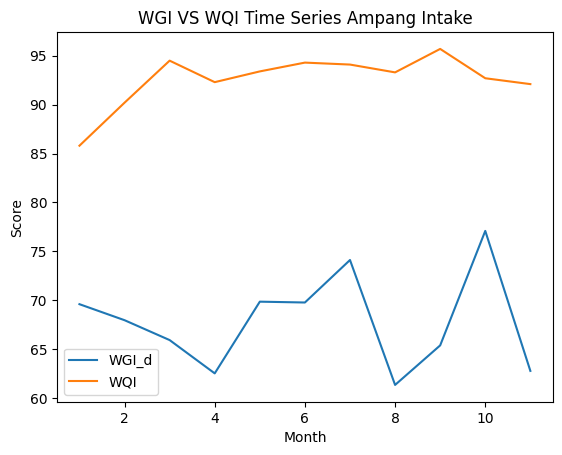

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Batang Kali')

Text(0, 0.5, 'Score')

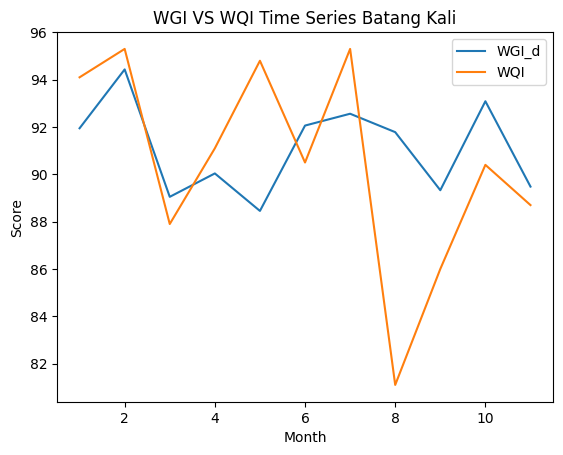

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Bernam River Headworks (New)')

Text(0, 0.5, 'Score')

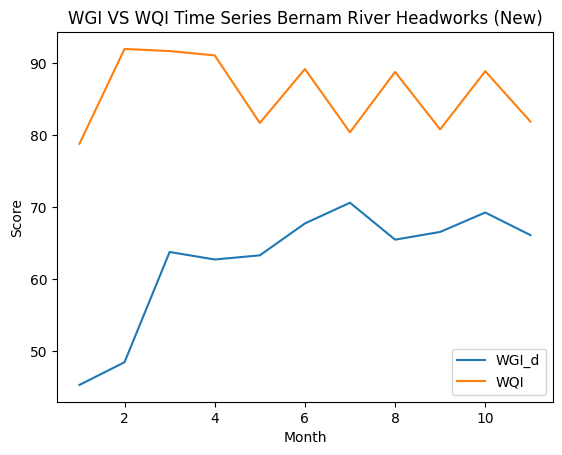

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Bernam River Headworks (Old)')

Text(0, 0.5, 'Score')

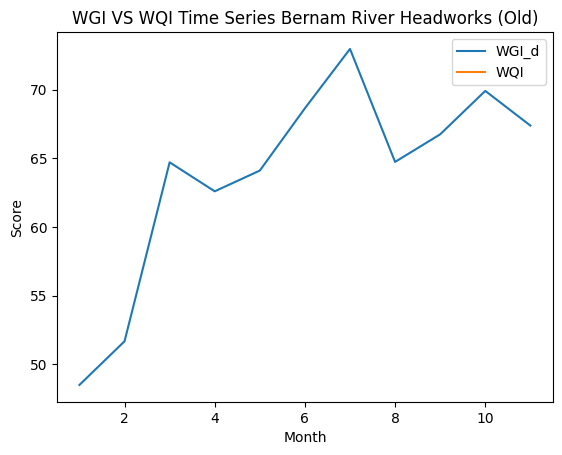

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Bukit Nanas')

Text(0, 0.5, 'Score')

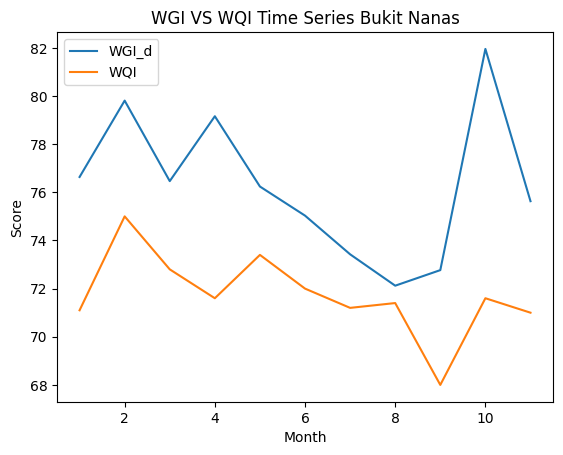

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Bukit Tampoi New')

Text(0, 0.5, 'Score')

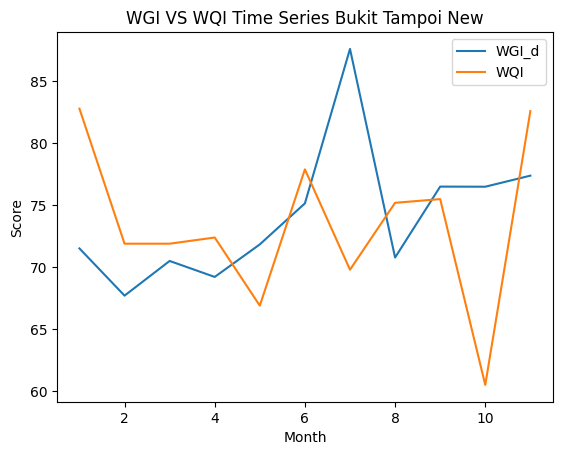

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Cheras Batu 11')

Text(0, 0.5, 'Score')

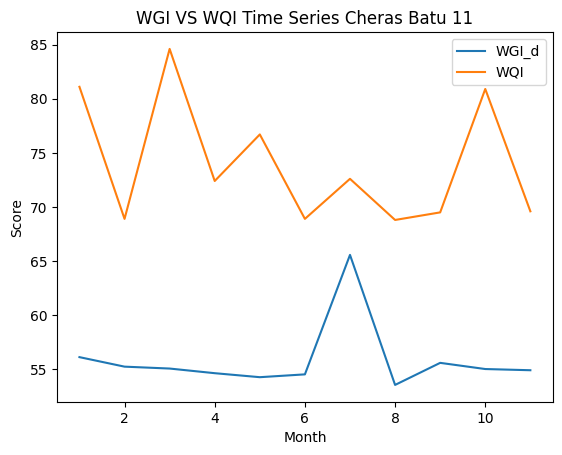

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Kalumpang')

Text(0, 0.5, 'Score')

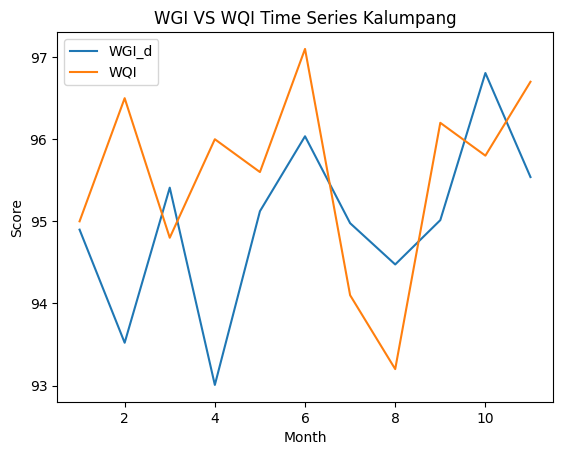

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Kepong')

Text(0, 0.5, 'Score')

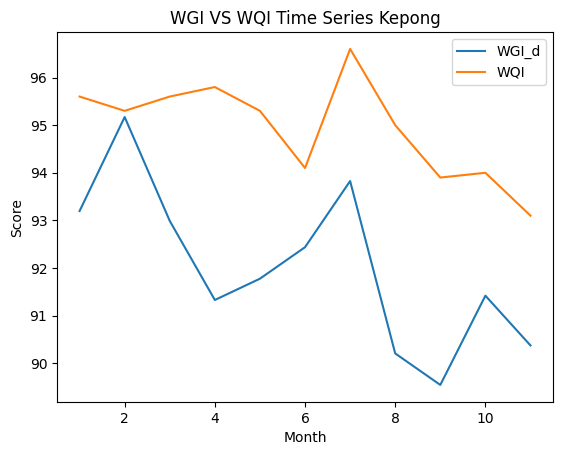

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Kuala Kubu Bharu')

Text(0, 0.5, 'Score')

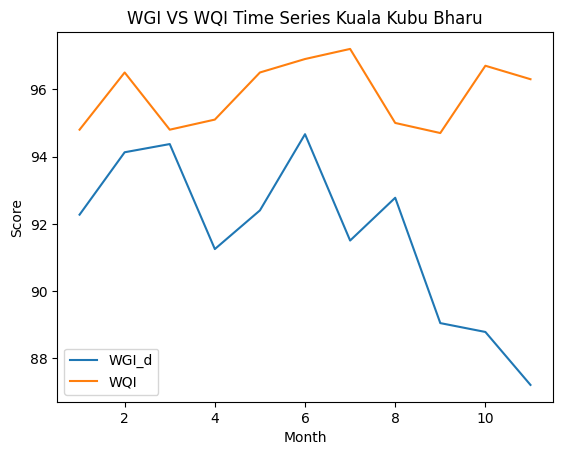

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Labohan Dagang')

Text(0, 0.5, 'Score')

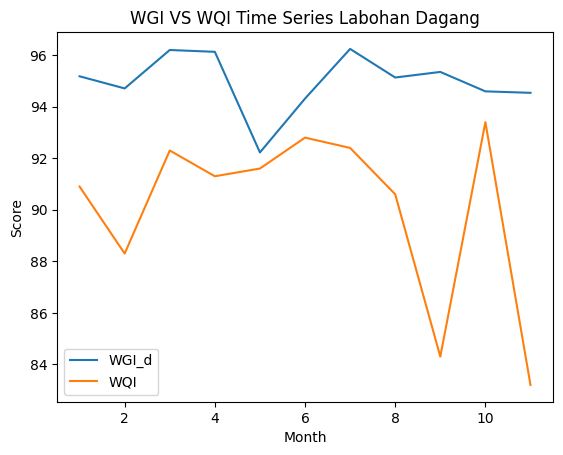

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Langat 2')

Text(0, 0.5, 'Score')

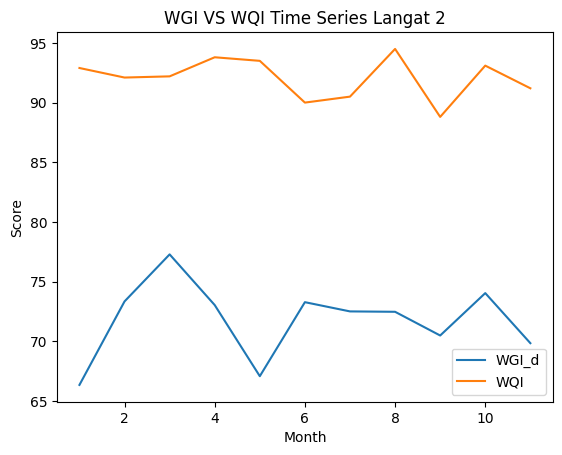

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series North Hummock')

Text(0, 0.5, 'Score')

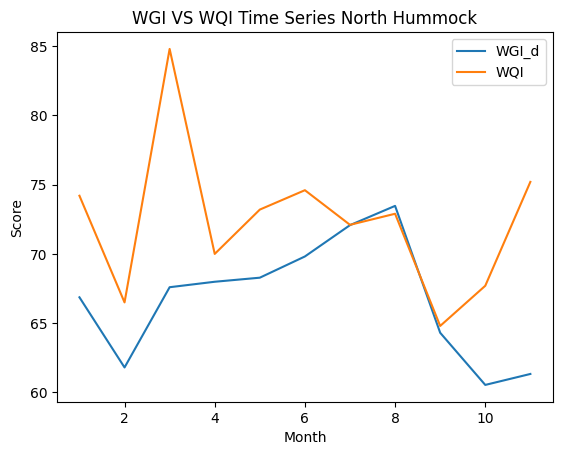

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Rantau Panjang New')

Text(0, 0.5, 'Score')

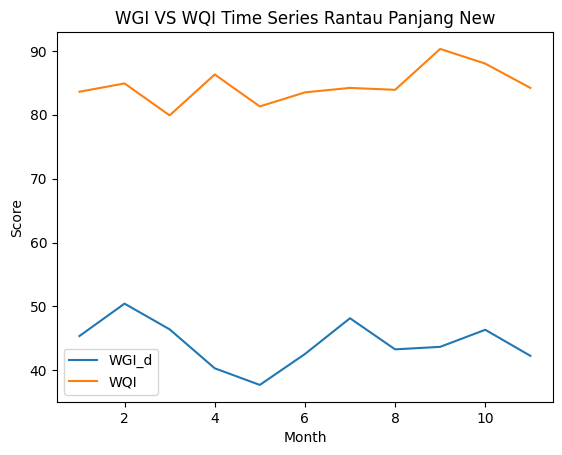

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Rantau Panjang Old')

Text(0, 0.5, 'Score')

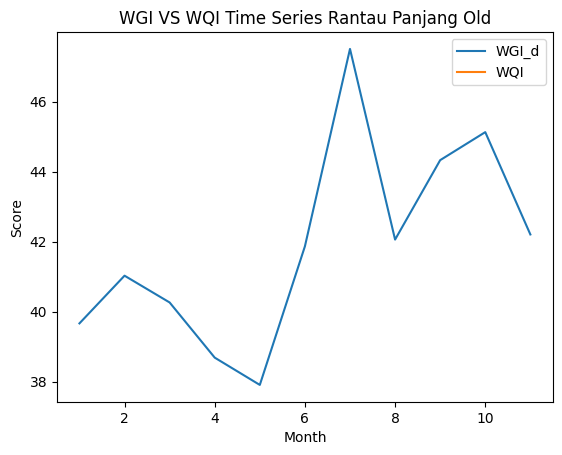

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Rasa')

Text(0, 0.5, 'Score')

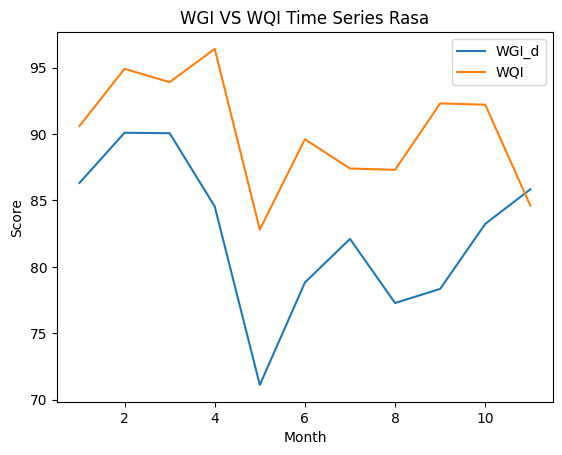

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Salak Tinggi')

Text(0, 0.5, 'Score')

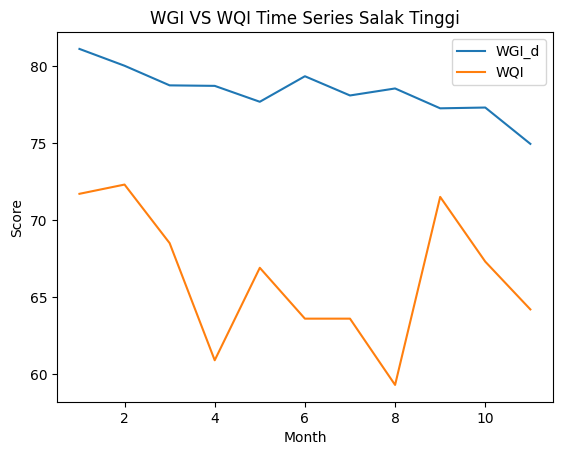

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Semenyih 2')

Text(0, 0.5, 'Score')

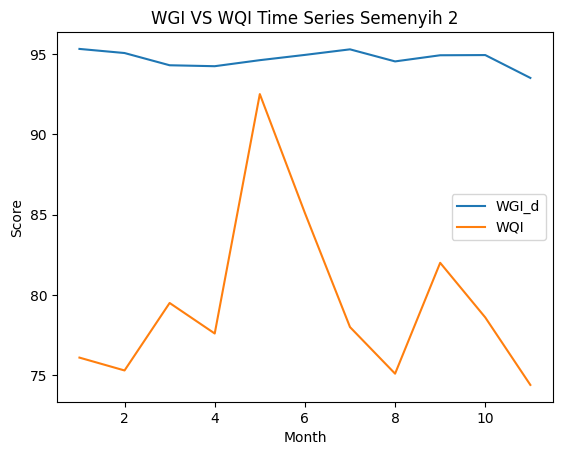

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Batu')

Text(0, 0.5, 'Score')

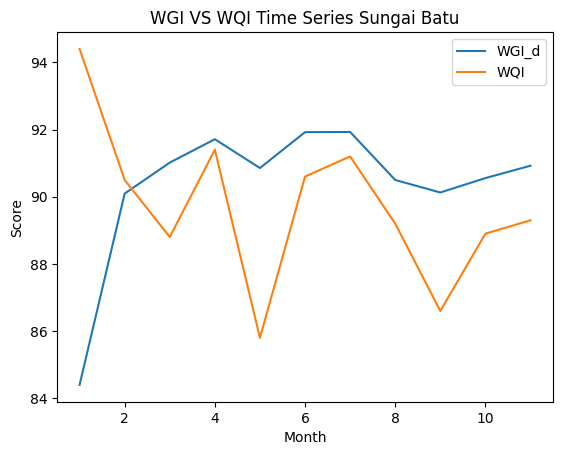

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Dusun')

Text(0, 0.5, 'Score')

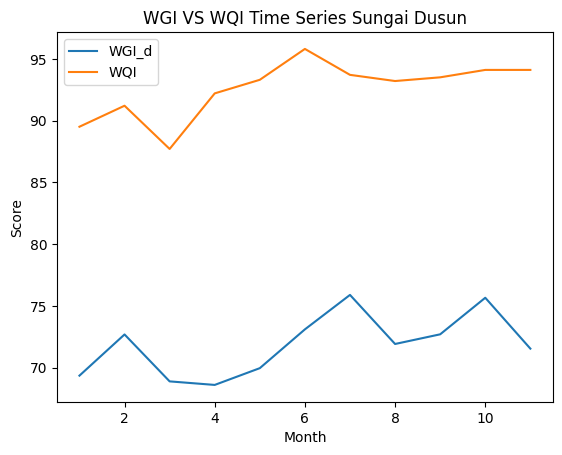

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Gombak')

Text(0, 0.5, 'Score')

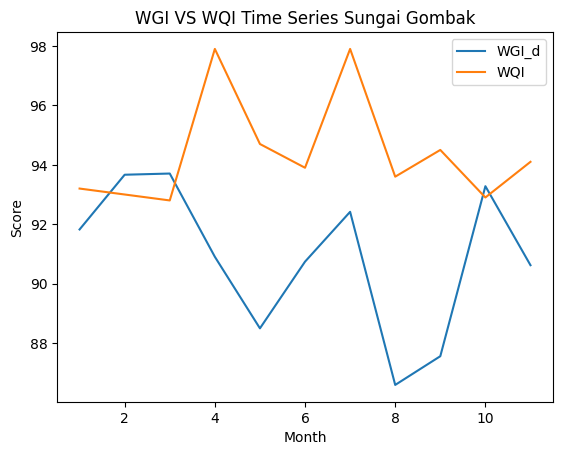

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Labu')

Text(0, 0.5, 'Score')

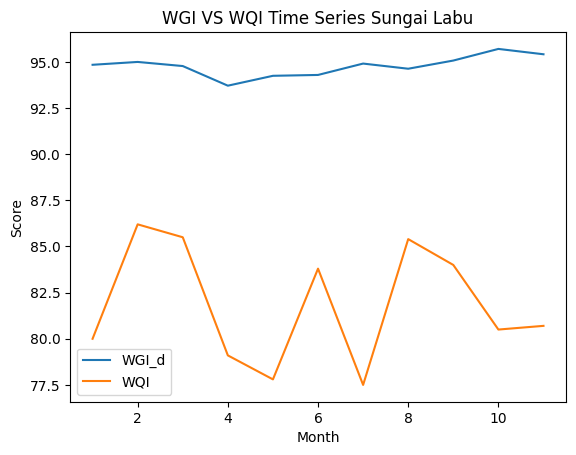

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Langat')

Text(0, 0.5, 'Score')

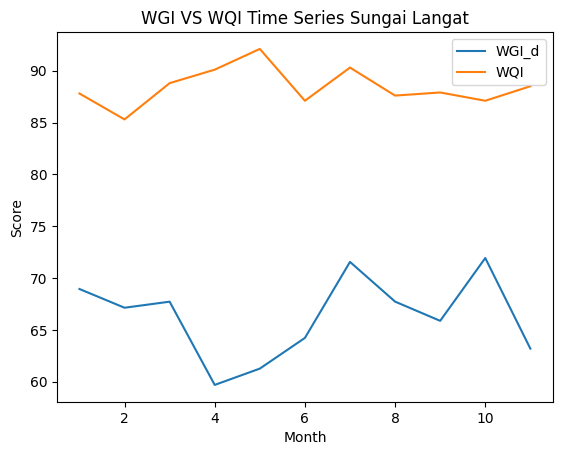

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Lolo - Baru')

Text(0, 0.5, 'Score')

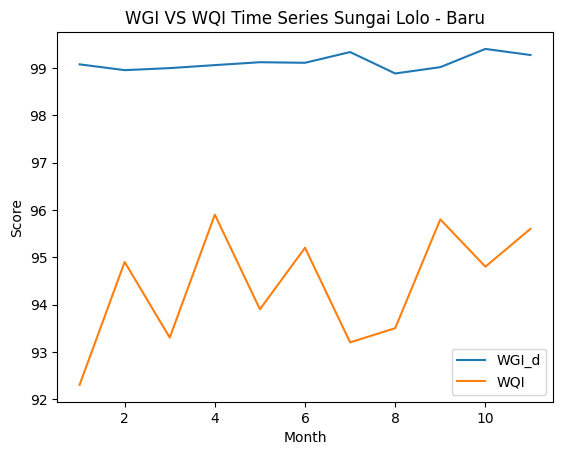

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Pangsoon')

Text(0, 0.5, 'Score')

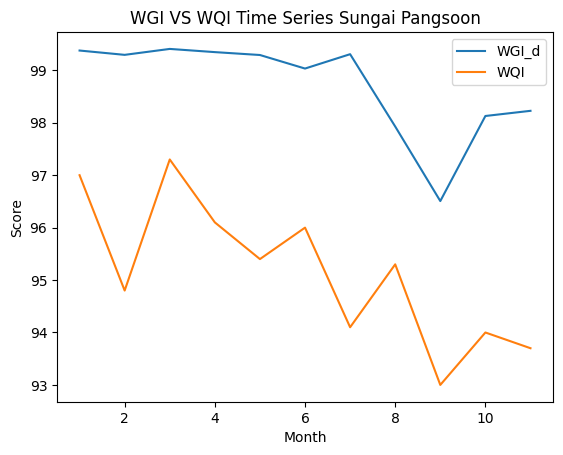

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Rangkap')

Text(0, 0.5, 'Score')

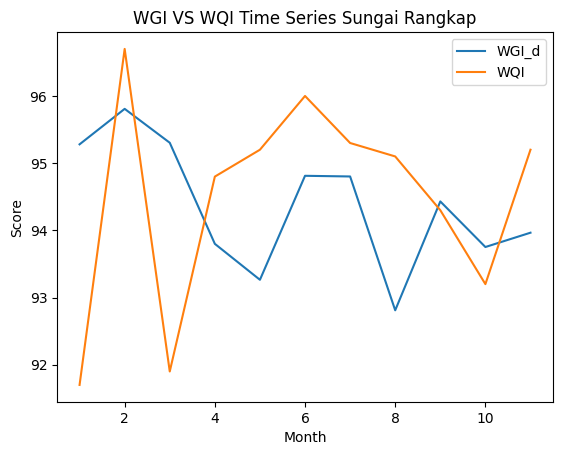

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Rumput')

Text(0, 0.5, 'Score')

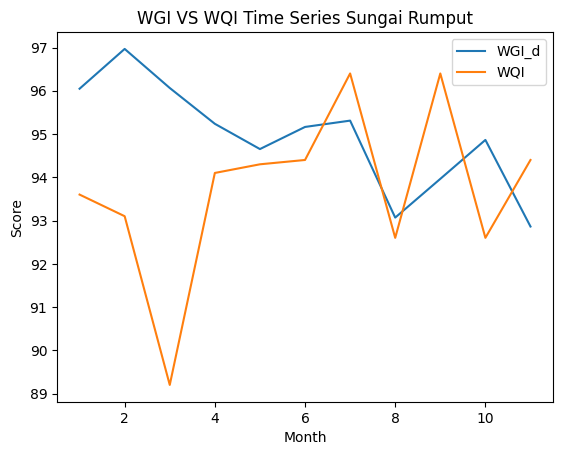

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Selangor Fasa 1')

Text(0, 0.5, 'Score')

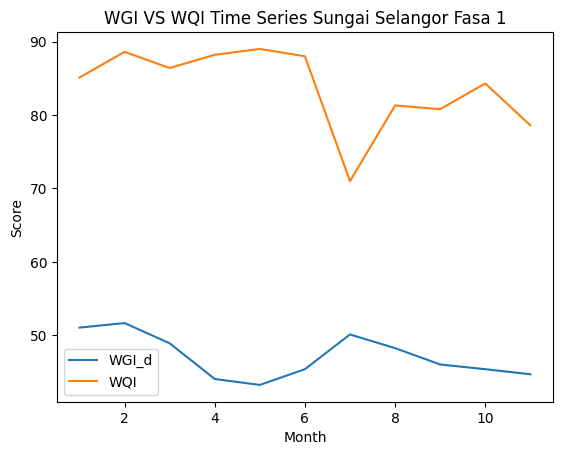

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Selangor Fasa 2 Stream C')

Text(0, 0.5, 'Score')

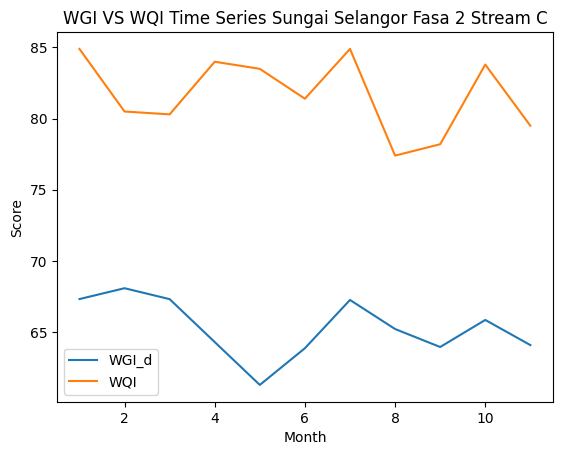

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Selangor Fasa 3')

Text(0, 0.5, 'Score')

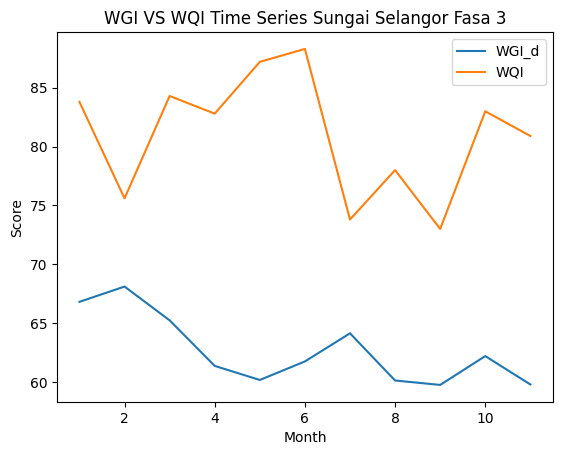

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Selisek')

Text(0, 0.5, 'Score')

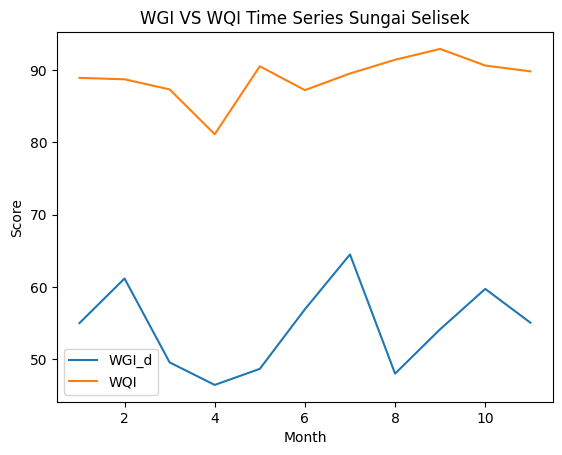

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Semenyih')

Text(0, 0.5, 'Score')

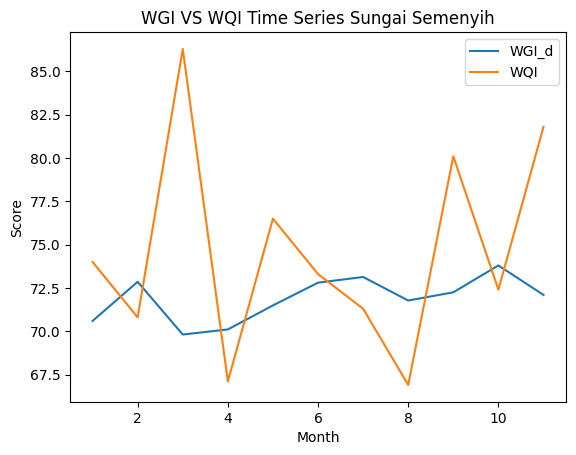

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Serai')

Text(0, 0.5, 'Score')

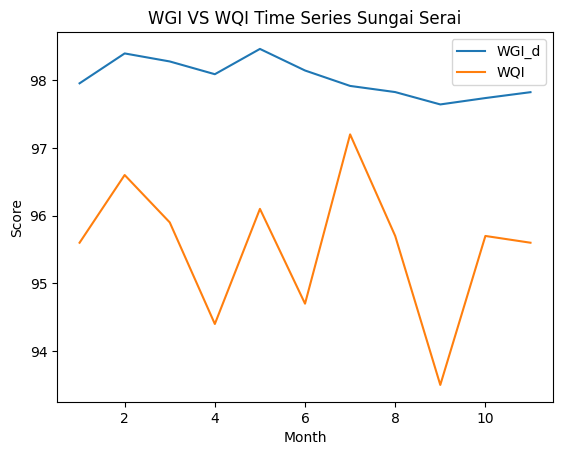

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Sireh')

Text(0, 0.5, 'Score')

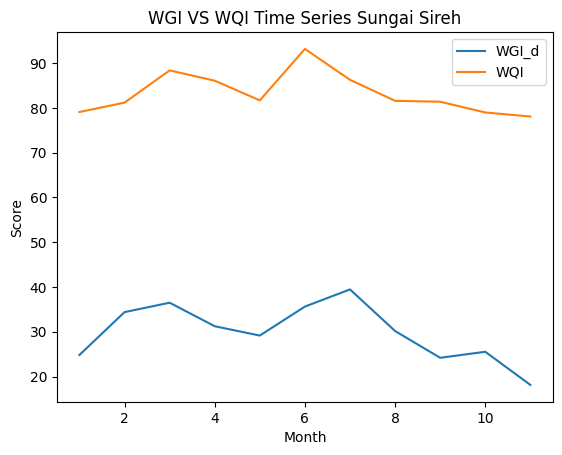

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Tengi')

Text(0, 0.5, 'Score')

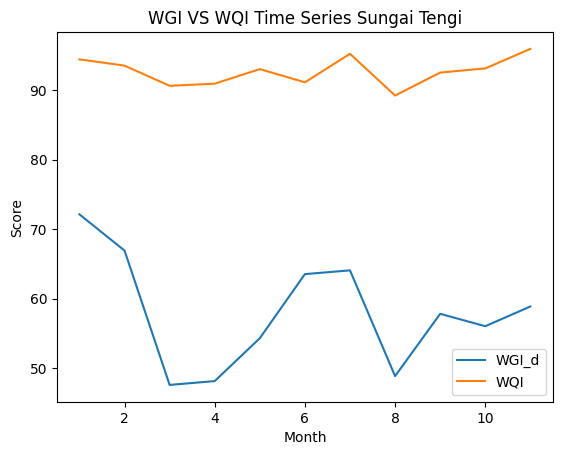

<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Wangsa Maju')

Text(0, 0.5, 'Score')

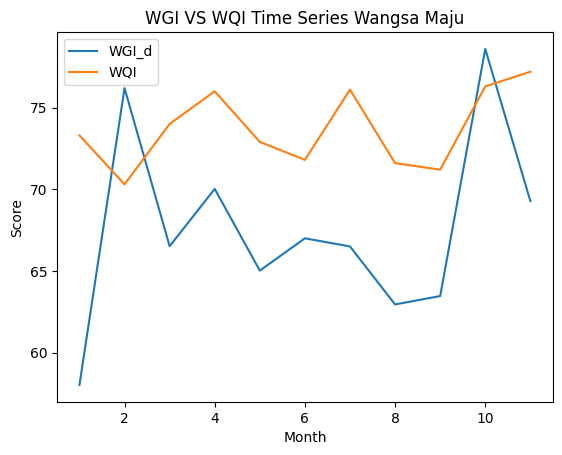

In [42]:
## General Plot to see how the WQI & WGI Differences
for i in c['wtp'].unique():
    c[c['wtp']==i].plot(x='Month',y=['WGI_d','WQI'])
    plt.title(f'WGI VS WQI Time Series {i}')
    plt.ylabel('Score')
    plt.show()

### WGI/WQI VS Actual Monthly Chemical Consumption (Linear Correlation)

In [43]:
## Loading Chemical File & Perform Data Regrouping
chedf = pd.read_csv('checons.csv')
chedf = chedf.rename(columns={'Flopam AH 912 PWG (25kg / bag).1':'Flopam AH 912 PWG (25kg / bag)'})
mdict = dict(zip(chedf['Month'].unique(),np.array(range(1,13,1))))
chedf['Month'] = chedf['Month'].apply(lambda x: mdict.get(x))
cgr = pd.read_csv("C.Grouping.csv")
cgr = cgr.rename(columns={'Chemical Name':'Chem'})

In [44]:
newdb = pd.merge(pd.DataFrame({'Chem':chedf.columns}),cgr,on='Chem',how='inner')
coa = newdb[newdb['Correct Grouping']=='Coagulant']['Chem'].unique()
pha = newdb[newdb['Correct Grouping']=='pH Adjuster']['Chem'].unique()
dis = newdb[newdb['Correct Grouping']=='Disinfectant']['Chem'].unique()

In [45]:
chedf['Coagulant'] = chedf[coa].sum(axis=1)
chedf['pH Adjuster'] = chedf[pha].sum(axis=1)
chedf['Disinfectant'] = chedf[dis].sum(axis=1)

In [46]:
fcl = ['Month', 'wtp', 'Coagulant','pH Adjuster', 'Disinfectant']
db1 = chedf[fcl].copy()
c2 = pd.merge(c,db1,on=['wtp','Month'],how='left')

In [47]:
## General Correlation Between Chemical Products & WGI/WQI
c2[['wtp','WQI','WGI_d','Coagulant','Disinfectant','pH Adjuster']].corr()

                   WQI     WGI_d  Coagulant  Disinfectant  pH Adjuster
WQI           1.000000  0.376361  -0.159966     -0.168895    -0.201372
WGI_d         0.376361  1.000000  -0.124621     -0.117359    -0.147432
Coagulant    -0.159966 -0.124621   1.000000      0.945101     0.957599
Disinfectant -0.168895 -0.117359   0.945101      1.000000     0.959291
pH Adjuster  -0.201372 -0.147432   0.957599      0.959291     1.000000

### WGI/WQI VS Actual Monthly Chemical Consumption (Elasticity of Grading)

In [48]:
the_name = ['pH_Sc', 'SS_sc', 'Co_Sc', 'Iron_Sc', 'Amm_Sc', 'Mgn_Sc', 'WGI','SIpH', 'SIDO', 'SISS', 'SIBOD', 'SICOD', 'SIAN','WQI','WGI_c','WGI_d', 'pH Adjuster', 'Disinfectant', 'Coagulant']
## Generate Daily % Changed 
for i in the_name:
    c2[f'{i}_chpctm'] = (c2.groupby('wtp')[i].shift(1)-c2[i])/c2[i]
    
## Parameters To Focus
tfi2 = ['pH Adjuster_chpctm','Disinfectant_chpctm','Coagulant_chpctm']

In [49]:
for i in tfi2:
    c2[f'Elas_WGI_G{i}'] = c2[i]/c2['WGI_chpctm']
    c2[f'Elas_WQI_{i}'] = c2[i]/c2['WQI_chpctm']
    c2[f'Elas_WGI_c{i}'] = c2[i]/c2['WGI_c_chpctm']
    c2[f'Elas_WGI_d{i}'] = c2[i]/c2['WGI_d_chpctm']

In [50]:
lmo = [x for x in c2.columns if "Elas_WGI_G" in x]
lmc = [x for x in c2.columns if "Elas_WGI_c" in x]
lmd = [x for x in c2.columns if "Elas_WGI_d" in x]
lmi = [x for x in c2.columns if "Elas_WQI_" in x]
lll = lmo + lmi + lmc + lmd

In [51]:
mdict = {'Parameters':[],'Median':[],'Count':[],'+ve_inf':[],'-ve_inf':[],'0_count':[]}
for i in lll:
    temp = c2[i].copy()
    temp1 = temp[~temp.isin([np.nan, np.inf, -np.inf,0])]
    mdict['Parameters'].append(i)
    mdict['Median'].append(temp1.median()) ## Get Median due to a good measure when there are outliers
    mdict['Count'].append(temp1.count())
    mdict['+ve_inf'].append(temp[temp.isin([np.inf])].count())
    mdict['-ve_inf'].append(temp[temp.isin([-np.inf])].count())
    mdict['0_count'].append(temp[temp.isin([0])].count())

In [52]:
result = pd.DataFrame(mdict)
result[result['Parameters'].isin(lmd)]

                       Parameters    Median  Count  +ve_inf  -ve_inf  0_count
9    Elas_WGI_dpH Adjuster_chpctm -1.381050    268        2        7        8
10  Elas_WGI_dDisinfectant_chpctm -0.552743    267        0        1       42
11     Elas_WGI_dCoagulant_chpctm -1.775768    247        2        6       11

## Unit Cost Comparison

In [53]:
uc = pd.read_csv('unit_cost_v2.csv')
uc = uc.rename(columns={'n_wtp':'wtp','UnitCost (cent per m3)':'Unit_cost'})
uc1 = uc[uc['Year']==2021].copy()

In [54]:
uc1

                              WTP                           wtp      Code  \
350                 Ampang Intake                 Ampang Intake  70110100   
351                   Batang Kali                   Batang Kali  70110100   
352  Bernam River Headworks (Old)  Bernam River Headworks (Old)  70110100   
353                   Bukit Nanas                   Bukit Nanas  70110100   
354                  Bukit Tampoi              Bukit Tampoi New  70110100   
..                            ...                           ...       ...   
765               Sungai Semenyih               Sungai Semenyih  70110100   
766                  Sungai Serai                  Sungai Serai  70110100   
767                  Sungai Sireh                  Sungai Sireh  70110100   
768                  Sungai Tengi                  Sungai Tengi  70110100   
769                   Wangsa Maju                   Wangsa Maju  70110100   

           Description  Amount per month (RM)  Production (m3 per month)  \

In [55]:
c

               wtp  Month      pH_Sc      SS_sc      Co_Sc    Iron_Sc  \
0    Ampang Intake      1  94.272226  77.936429  15.974409  82.258065   
1    Ampang Intake      2  91.951318  79.195662  16.775476  74.928571   
2    Ampang Intake      3  96.176716  72.510342  18.221075  64.322581   
3    Ampang Intake      4  97.315084  53.718742  13.356222  62.900000   
4    Ampang Intake      5  97.919979  65.203649  30.290968  73.387097   
..             ...    ...        ...        ...        ...        ...   
391    Wangsa Maju      7  94.505824  94.634673  60.431828  18.967742   
392    Wangsa Maju      8  94.480316  93.364462  47.905161  17.774194   
393    Wangsa Maju      9  94.509123  92.930453  43.212667  26.100000   
394    Wangsa Maju     10  94.051354  95.279909  70.273333  61.548387   
395    Wangsa Maju     11  94.071947  95.038127  65.688667  25.566667   

        Amm_Sc      Mgn_Sc        WGI      WGI_c      WGI_d     DMonth  \
0    85.575580  100.000000  72.251664  73.594621 

In [56]:
fc = pd.merge(c,uc1[['wtp','Month','Unit_cost']],on=['wtp','Month'],how='left')

In [61]:
fr = pd.merge(fc,master_db[['wtp']],on = 'wtp',how = 'left')
fr = fr[(fr['Lembangan'] == 'Sg Selangor')]
columns_target = 'wtp'
core_unit_wgi = []
wtp_corr = []
#columns_target = 'Lembangan'
for i in fr[columns_target].unique():
    # fr[fr[columns_target]==i].plot(x='Month',y=['WGI_d'])
    # plt.title(f'WGI Time Series {i}')
    # plt.ylabel('Score')
    # plt.show()
    # fr[fr[columns_target]==i].plot(x='Month',y=['Unit_cost'])
    # plt.title(f'Unit Cost Time Series {i}')
    # plt.ylabel('Score')
    # plt.show()
    k = fr[(fr['wtp'] ==i)]
    k

              wtp  Month      pH_Sc      SS_sc      Co_Sc    Iron_Sc  \
3663  Batang Kali      1  98.584898  90.715256  97.207957  80.838710   
3664  Batang Kali      1  98.584898  90.715256  97.207957  80.838710   
3665  Batang Kali      1  98.584898  90.715256  97.207957  80.838710   
3666  Batang Kali      1  98.584898  90.715256  97.207957  80.838710   
3667  Batang Kali      1  98.584898  90.715256  97.207957  80.838710   
...           ...    ...        ...        ...        ...        ...   
7332  Batang Kali     11  99.055248  81.717353  99.626222  74.066667   
7333  Batang Kali     11  99.055248  81.717353  99.626222  74.066667   
7334  Batang Kali     11  99.055248  81.717353  99.626222  74.066667   
7335  Batang Kali     11  99.055248  81.717353  99.626222  74.066667   
7336  Batang Kali     11  99.055248  81.717353  99.626222  74.066667   

         Amm_Sc     Mgn_Sc        WGI      WGI_c      WGI_d     DMonth  \
3663  88.749174  90.000000  93.277217  92.624683  91.946860 2

                    wtp  Month      pH_Sc      SS_sc      Co_Sc    Iron_Sc  \
25696  Kuala Kubu Bharu      1  99.265210  92.037267  82.460215  93.483871   
25697  Kuala Kubu Bharu      1  99.265210  92.037267  82.460215  93.483871   
25698  Kuala Kubu Bharu      1  99.265210  92.037267  82.460215  93.483871   
25699  Kuala Kubu Bharu      1  99.265210  92.037267  82.460215  93.483871   
25700  Kuala Kubu Bharu      1  99.265210  92.037267  82.460215  93.483871   
...                 ...    ...        ...        ...        ...        ...   
29365  Kuala Kubu Bharu     11  98.774421  91.776724  68.859778  91.533333   
29366  Kuala Kubu Bharu     11  98.774421  91.776724  68.859778  91.533333   
29367  Kuala Kubu Bharu     11  98.774421  91.776724  68.859778  91.533333   
29368  Kuala Kubu Bharu     11  98.774421  91.776724  68.859778  91.533333   
29369  Kuala Kubu Bharu     11  98.774421  91.776724  68.859778  91.533333   

          Amm_Sc     Mgn_Sc        WGI      WGI_c      WGI_d   

                      wtp  Month      pH_Sc      SS_sc      Co_Sc   Iron_Sc  \
33066  Rantau Panjang New      1  96.810682  59.174614  12.506452  3.064516   
33067  Rantau Panjang New      1  96.810682  59.174614  12.506452  3.064516   
33068  Rantau Panjang New      1  96.810682  59.174614  12.506452  3.064516   
33069  Rantau Panjang New      1  96.810682  59.174614  12.506452  3.064516   
33070  Rantau Panjang New      1  96.810682  59.174614  12.506452  3.064516   
...                   ...    ...        ...        ...        ...       ...   
36735  Rantau Panjang New     11  95.675585  45.155332   8.870889  3.400000   
36736  Rantau Panjang New     11  95.675585  45.155332   8.870889  3.400000   
36737  Rantau Panjang New     11  95.675585  45.155332   8.870889  3.400000   
36738  Rantau Panjang New     11  95.675585  45.155332   8.870889  3.400000   
36739  Rantau Panjang New     11  95.675585  45.155332   8.870889  3.400000   

          Amm_Sc    Mgn_Sc        WGI      WGI_c   

                      wtp  Month      pH_Sc      SS_sc  Co_Sc  Iron_Sc  \
36740  Rantau Panjang Old      1  96.113846  49.732787    0.0      0.0   
36741  Rantau Panjang Old      1  96.113846  49.732787    0.0      0.0   
36742  Rantau Panjang Old      1  96.113846  49.732787    0.0      0.0   
36743  Rantau Panjang Old      1  96.113846  49.732787    0.0      0.0   
36744  Rantau Panjang Old      1  96.113846  49.732787    0.0      0.0   
...                   ...    ...        ...        ...    ...      ...   
40409  Rantau Panjang Old     11  96.697374  32.622002    0.0     16.5   
40410  Rantau Panjang Old     11  96.697374  32.622002    0.0     16.5   
40411  Rantau Panjang Old     11  96.697374  32.622002    0.0     16.5   
40412  Rantau Panjang Old     11  96.697374  32.622002    0.0     16.5   
40413  Rantau Panjang Old     11  96.697374  32.622002    0.0     16.5   

          Amm_Sc     Mgn_Sc        WGI      WGI_c      WGI_d DMonth  WTP  \
36740  68.417622   9.516129  45.287

        wtp  Month      pH_Sc      SS_sc      Co_Sc    Iron_Sc     Amm_Sc  \
40414  Rasa      1  98.686595  90.863699  85.040000  55.612903  99.958065   
40415  Rasa      1  98.686595  90.863699  85.040000  55.612903  99.958065   
40416  Rasa      1  98.686595  90.863699  85.040000  55.612903  99.958065   
40417  Rasa      1  98.686595  90.863699  85.040000  55.612903  99.958065   
40418  Rasa      1  98.686595  90.863699  85.040000  55.612903  99.958065   
...     ...    ...        ...        ...        ...        ...        ...   
44083  Rasa     11  99.339405  89.643951  89.356889  49.433333  98.855000   
44084  Rasa     11  99.339405  89.643951  89.356889  49.433333  98.855000   
44085  Rasa     11  99.339405  89.643951  89.356889  49.433333  98.855000   
44086  Rasa     11  99.339405  89.643951  89.356889  49.433333  98.855000   
44087  Rasa     11  99.339405  89.643951  89.356889  49.433333  98.855000   

          Mgn_Sc        WGI      WGI_c      WGI_d     DMonth   WTP       SI

                  wtp  Month      pH_Sc      SS_sc      Co_Sc    Iron_Sc  \
66154  Sungai Rangkap      1  98.957789  95.673426  97.858495  88.290323   
66155  Sungai Rangkap      1  98.957789  95.673426  97.858495  88.290323   
66156  Sungai Rangkap      1  98.957789  95.673426  97.858495  88.290323   
66157  Sungai Rangkap      1  98.957789  95.673426  97.858495  88.290323   
66158  Sungai Rangkap      1  98.957789  95.673426  97.858495  88.290323   
...               ...    ...        ...        ...        ...        ...   
69823  Sungai Rangkap     11  98.314783  93.224531  97.333333  89.733333   
69824  Sungai Rangkap     11  98.314783  93.224531  97.333333  89.733333   
69825  Sungai Rangkap     11  98.314783  93.224531  97.333333  89.733333   
69826  Sungai Rangkap     11  98.314783  93.224531  97.333333  89.733333   
69827  Sungai Rangkap     11  98.314783  93.224531  97.333333  89.733333   

          Amm_Sc     Mgn_Sc        WGI      WGI_c      WGI_d     DMonth  \
66154  96.43

                          wtp  Month      pH_Sc      SS_sc     Co_Sc  \
69839  Sungai Selangor Fasa 1      1  94.002215  71.656653  0.376344   
69840  Sungai Selangor Fasa 1      1  94.002215  71.656653  0.376344   
69841  Sungai Selangor Fasa 1      1  94.002215  71.656653  0.376344   
69842  Sungai Selangor Fasa 1      1  94.002215  71.656653  0.376344   
69843  Sungai Selangor Fasa 1      1  94.002215  71.656653  0.376344   
...                       ...    ...        ...        ...       ...   
73497  Sungai Selangor Fasa 1     11  96.108645  48.530930  0.000000   
73498  Sungai Selangor Fasa 1     11  96.108645  48.530930  0.000000   
73499  Sungai Selangor Fasa 1     11  96.108645  48.530930  0.000000   
73500  Sungai Selangor Fasa 1     11  96.108645  48.530930  0.000000   
73501  Sungai Selangor Fasa 1     11  96.108645  48.530930  0.000000   

        Iron_Sc     Amm_Sc     Mgn_Sc        WGI      WGI_c      WGI_d  \
69839  8.483871  95.961290  51.612903  56.230593  55.745062  

                                   wtp  Month      pH_Sc      SS_sc  \
73502  Sungai Selangor Fasa 2 Stream C      1  94.063864  48.442707   
73503  Sungai Selangor Fasa 2 Stream C      1  94.063864  48.442707   
73504  Sungai Selangor Fasa 2 Stream C      1  94.063864  48.442707   
73505  Sungai Selangor Fasa 2 Stream C      1  94.063864  48.442707   
73506  Sungai Selangor Fasa 2 Stream C      1  94.063864  48.442707   
...                                ...    ...        ...        ...   
77171  Sungai Selangor Fasa 2 Stream C     11  94.311891  41.983084   
77172  Sungai Selangor Fasa 2 Stream C     11  94.311891  41.983084   
77173  Sungai Selangor Fasa 2 Stream C     11  94.311891  41.983084   
77174  Sungai Selangor Fasa 2 Stream C     11  94.311891  41.983084   
77175  Sungai Selangor Fasa 2 Stream C     11  94.311891  41.983084   

           Co_Sc   Iron_Sc     Amm_Sc     Mgn_Sc        WGI      WGI_c  \
73502  95.044086  9.677419  76.008569  22.903226  68.938666  65.736827   

                          wtp  Month      pH_Sc      SS_sc      Co_Sc  \
77176  Sungai Selangor Fasa 3      1  93.058642  55.241844  91.023441   
77177  Sungai Selangor Fasa 3      1  93.058642  55.241844  91.023441   
77178  Sungai Selangor Fasa 3      1  93.058642  55.241844  91.023441   
77179  Sungai Selangor Fasa 3      1  93.058642  55.241844  91.023441   
77180  Sungai Selangor Fasa 3      1  93.058642  55.241844  91.023441   
...                       ...    ...        ...        ...        ...   
80834  Sungai Selangor Fasa 3     11  84.008694  42.581882  75.816444   
80835  Sungai Selangor Fasa 3     11  84.008694  42.581882  75.816444   
80836  Sungai Selangor Fasa 3     11  84.008694  42.581882  75.816444   
80837  Sungai Selangor Fasa 3     11  84.008694  42.581882  75.816444   
80838  Sungai Selangor Fasa 3     11  84.008694  42.581882  75.816444   

        Iron_Sc     Amm_Sc     Mgn_Sc        WGI      WGI_c      WGI_d  \
77176  0.290323  89.187097  10.322581  67.994325 

## Graph

t-value = 1528.134, p-value = 0.000


<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Batang Kali Corr:-0.16')

Text(0, 0.5, 'Score')

<AxesSubplot:title={'center':'WGI VS WQI Time Series Batang Kali Corr:-0.16'}>

Text(0.5, 1.0, 'Batang Kali')

t-value = 2247.370, p-value = 0.000


<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Kuala Kubu Bharu Corr:-0.72')

Text(0, 0.5, 'Score')

<AxesSubplot:title={'center':'WGI VS WQI Time Series Kuala Kubu Bharu Corr:-0.72'}>

Text(0.5, 1.0, 'Kuala Kubu Bharu')

t-value = 671.220, p-value = 0.000


<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Rantau Panjang New Corr:-0.16')

Text(0, 0.5, 'Score')

<AxesSubplot:title={'center':'WGI VS WQI Time Series Rantau Panjang New Corr:-0.16'}>

Text(0.5, 1.0, 'Rantau Panjang New')

t-value = nan, p-value = nan


All-NaN slice encountered
All-NaN slice encountered


<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Rantau Panjang Old Corr:nan')

Text(0, 0.5, 'Score')

<AxesSubplot:title={'center':'WGI VS WQI Time Series Rantau Panjang Old Corr:nan'}>

Text(0.5, 1.0, 'Rantau Panjang Old')

t-value = 908.960, p-value = 0.000


<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Rasa Corr:-0.42')

Text(0, 0.5, 'Score')

<AxesSubplot:title={'center':'WGI VS WQI Time Series Rasa Corr:-0.42'}>

Text(0.5, 1.0, 'Rasa')

t-value = 4915.450, p-value = 0.000


<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Rangkap Corr:-0.09')

Text(0, 0.5, 'Score')

<AxesSubplot:title={'center':'WGI VS WQI Time Series Sungai Rangkap Corr:-0.09'}>

Text(0.5, 1.0, 'Sungai Rangkap')

t-value = 980.745, p-value = 0.000


<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Selangor Fasa 1 Corr:-0.87')

Text(0, 0.5, 'Score')

<AxesSubplot:title={'center':'WGI VS WQI Time Series Sungai Selangor Fasa 1 Corr:-0.87'}>

Text(0.5, 1.0, 'Sungai Selangor Fasa 1')

t-value = 1849.512, p-value = 0.000


<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Selangor Fasa 2 Stream C Corr:-0.91')

Text(0, 0.5, 'Score')

<AxesSubplot:title={'center':'WGI VS WQI Time Series Sungai Selangor Fasa 2 Stream C Corr:-0.91'}>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream C')

t-value = 1342.403, p-value = 0.000


<AxesSubplot:xlabel='Month'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Selangor Fasa 3 Corr:nan')

Text(0, 0.5, 'Score')

<AxesSubplot:title={'center':'WGI VS WQI Time Series Sungai Selangor Fasa 3 Corr:nan'}>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3')

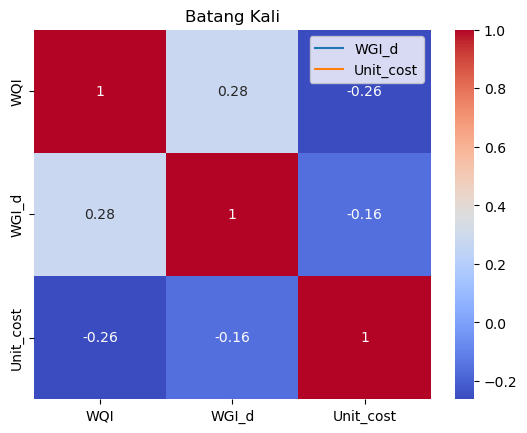

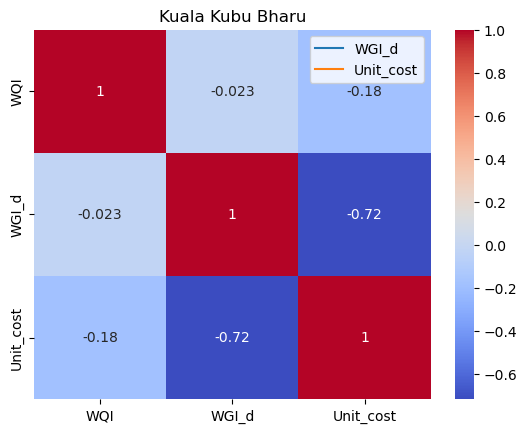

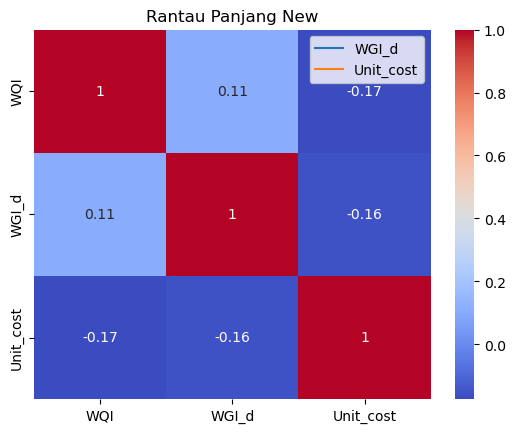

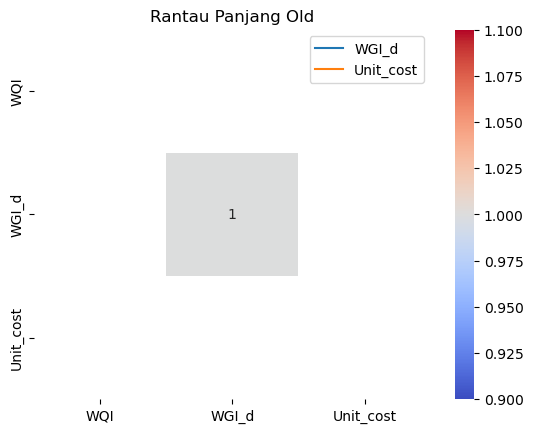

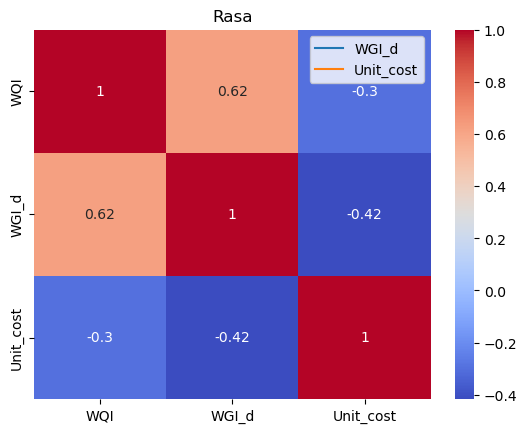

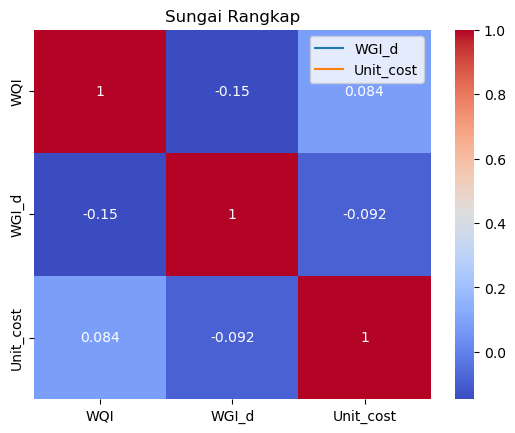

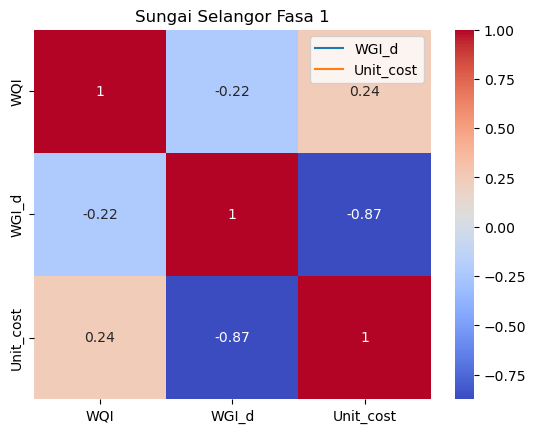

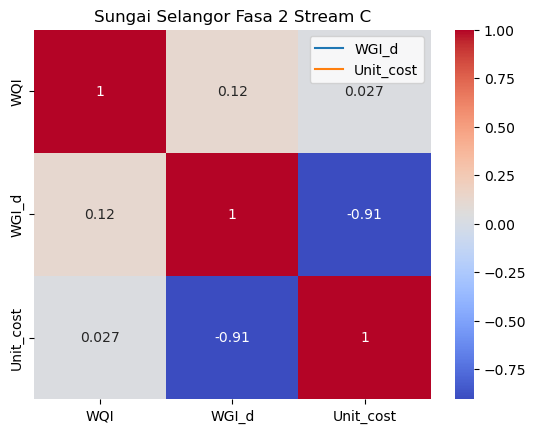

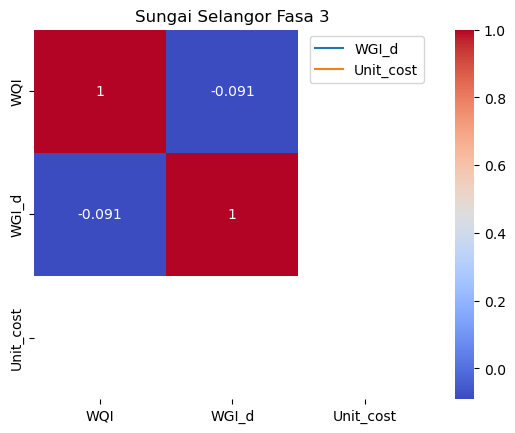

In [217]:
fr = pd.merge(fc,master_db[['wtp']],on = 'wtp',how = 'left')

# define the conditions
#condition = (fr['wtp'] == 'Kuala Kubu Bharu') | (fr['wtp'] == 'Batang Kali')| (fr['wtp'] == 'Sungai Rangkap')
# use loc to update the values
#fr.loc[condition, 'Lembangan'] = 'Sungai Selangor Upstream'

#fr = fr[(fr['wtp'] != 'Sungai Selangor Fasa 2 Stream C') & (fr['wtp'] != 'Bukit Tampoi New') & (fr['wtp'] != 'Salak Tinggi')& (fr['wtp'] != 'Sungai Serai') ]
fr = fr[(fr['Lembangan'] == 'Sg Selangor')]
# for i in c['wtp'].unique():
#     c[c['wtp']==i].plot(x='Month',y=['WGI_d','WQI'])
#     plt.title(f'WGI VS WQI Time Series {i}')
#     plt.ylabel('Score')
#     plt.show()
#fr[['Unit_cost']] = fr[['Unit_cost']].multiply(10)
columns_target = 'wtp'
core_unit_wgi = []
wtp_corr = []
#columns_target = 'Lembangan'
for i in fr[columns_target].unique():
    # fr[fr[columns_target]==i].plot(x='Month',y=['WGI_d'])
    # plt.title(f'WGI Time Series {i}')
    # plt.ylabel('Score')
    # plt.show()
    # fr[fr[columns_target]==i].plot(x='Month',y=['Unit_cost'])
    # plt.title(f'Unit Cost Time Series {i}')
    # plt.ylabel('Score')
    # plt.show()
    core = fr[fr[columns_target] == i][['WQI','WGI_d','Unit_cost']].corr()
    core_unit_wgi.append(core['Unit_cost'][1])
    corr_val =round(core['Unit_cost'][1],2)
    #for i in c['wtp'].unique():
    
    a = fr[fr['wtp']==i].copy()
    t, p = stats.ttest_ind(a['WGI_d'], a['Unit_cost'])

    # print the results
    print("t-value = {:.3f}, p-value = {:.3f}".format(t, p))
    scaler = MinMaxScaler(feature_range=(a['WGI_d'].min(), a['WGI_d'].max()))
    a['Unit_cost'] = scaler.fit_transform(a[['Unit_cost']])
    a.plot(x='Month',y=['WGI_d','Unit_cost'])
    plt.title(f'WGI VS WQI Time Series {i} Corr:{corr_val}')
    plt.ylabel('Score')
    save = f'Plot/Sg_Sel/{i}WGI_UnitCost_TimeSeries_plot_Sg_Selangor.png'
    plt.savefig(save)
    #plt.show()
    wtp_corr.append(i) 
    sns.heatmap(core, annot=True, cmap='coolwarm')
    plt.title(i)
    #plt.show()
    save = f'Plot/Sg_Sel/{i}WGI_UnitCost_Corr_plot_Sg_Selangor.png'
    plt.savefig(save)

data = {'wtp': wtp_corr,
        'corr_wgi_unit': core_unit_wgi}
  
# Create DataFrame
corr_df = pd.DataFrame(data)

In [218]:
fr.columns

Index(['wtp', 'Month', 'pH_Sc', 'SS_sc', 'Co_Sc', 'Iron_Sc', 'Amm_Sc',
       'Mgn_Sc', 'WGI', 'WGI_c', 'WGI_d', 'DMonth', 'WTP', 'SIpH', 'SIDO',
       'SISS', 'SIBOD', 'SICOD', 'SIAN', 'WQI', 'Diff', 'Lembangan',
       'Unit_cost'],
      dtype='object')

In [219]:
corr_df.sort_values('corr_wgi_unit')  #[corr_df['corr_wgi_unit'] > -0.]#['wtp'].to_list()
corr_df.to_csv('Plot\Result\correlation_unified_weight_WGI_Sg_Selangor.csv')

,wtp,corr_wgi_unit
7,Sungai Selangor Fasa 2 Stream C,-0.905298
6,Sungai Selangor Fasa 1,-0.874760
1,Kuala Kubu Bharu,-0.718813
4,Rasa,-0.416657
0,Batang Kali,-0.160771
2,Rantau Panjang New,-0.156498
5,Sungai Rangkap,-0.092076
3,Rantau Panjang Old,NaN
8,Sungai Selangor Fasa 3,NaN


<AxesSubplot:>

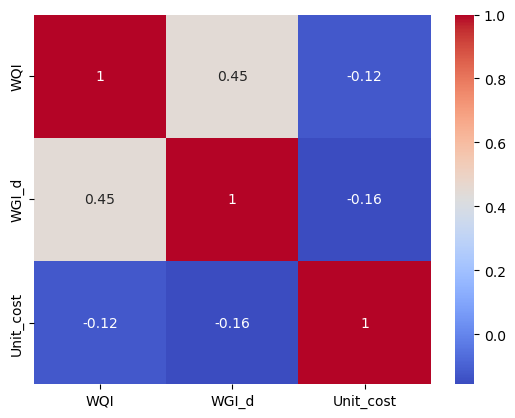

In [64]:
core = fr[['WQI','WGI_d','Unit_cost']].corr()
sns.heatmap(core, annot=True, cmap='coolwarm')

In [66]:
fc.groupby('wtp')[['WGI_d','WQI','Unit_cost']].mean().sort_values(by='WGI_d',ascending=False)

,WGI_d,WQI,Unit_cost
wtp,,,
Sungai Lolo - Baru,95.720776,94.400000,4.527599
Sungai Pangsoon,95.407785,95.154545,3.653661
Sungai Serai,94.712647,95.545455,10.487718
Sungai Rumput,92.395470,93.736364,16.685140
Kalumpang,91.752331,95.545455,4.865266
Labohan Dagang,91.400315,90.100000,6.421107
Sungai Labu,90.552404,81.863636,2.871870
Sungai Rangkap,90.233071,94.490909,4.721915
Semenyih 2,90.133670,79.472727,5.699350
